In [37]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime, timedelta

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_curve
import scipy.optimize as tnc
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file
'''
SQL-like Functions in Pandas: https://towardsdatascience.com/sql-window-functions-in-python-pandas-data-science-dc7c7a63cbb4
'''

'\nSQL-like Functions in Pandas: https://towardsdatascience.com/sql-window-functions-in-python-pandas-data-science-dc7c7a63cbb4\n'

### Fetching Equity data

In [38]:
equity_df = fetch_sql_code('''select * from equity_value_data''')
equity_df

timestamp  close_equity                           user_id
0       2016-10-03       27.2775  f5fc78a6931c205931827765e5b853f8
1       2016-10-04       24.9530  f5fc78a6931c205931827765e5b853f8
2       2016-10-05       27.5455  f5fc78a6931c205931827765e5b853f8
3       2016-10-06       26.8200  f5fc78a6931c205931827765e5b853f8
4       2016-10-07       25.9181  f5fc78a6931c205931827765e5b853f8
...            ...           ...                               ...
1119153 2016-09-26       21.9035  f5fc78a6931c205931827765e5b853f8
1119154 2016-09-27       22.0865  f5fc78a6931c205931827765e5b853f8
1119155 2016-09-28       24.4820  f5fc78a6931c205931827765e5b853f8
1119156 2016-09-29       23.7011  f5fc78a6931c205931827765e5b853f8
1119157 2016-09-30       22.8695  f5fc78a6931c205931827765e5b853f8

[1119158 rows x 3 columns]

### Equity Volatility | 1 Standard Deviation of Equity

In [39]:
'''
- Why it's useful:
Volatility is a key measure in finance, as it represents the risk or stability of a user’s portfolio over time.
High volatility could indicate speculative behavior, which might correlate with churn or certain types of investment
activity.
- How to calculate:
1sd = 68% of the time the spread of the data is between + or - (mean +/- 1*sd value)
2sd = 95% of the time the spread of the data is between + or - (mean +/- 2*sd value)
3sd = 99.7% of the time the spread of the data is between + or - (mean +/- 3*sd value)
'''
# Calculating standard deviation for each user assumes that each user has 2+ rows of data in equity_df.
new_df = equity_df.groupby('user_id')['close_equity'].std().reset_index()
new_df.columns = ['user_id', 'equity_volatility']
new_df

user_id  equity_volatility
0     0012db34aa7b083f5714e7831195e54d         191.975127
1     001d6c77dbdb3213cead7673f250bfdc         449.330147
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472
3     00384fa9be6fdca1b786bae70d78f88f          24.522490
4     0042aac295a0d4df88f4b83012778bd4         933.690027
...                                ...                ...
5579  ff9ee08791e20724a86995ab2bc72578          47.137114
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485
5581  ffae713096867a32e74f633060667153           7.194193
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605

[5584 rows x 2 columns]

In [40]:
# equity_volatility contains 4 rows of missing data stored into null_rows
print(f"Null Counts: \n", new_df.isnull().sum())
null_rows = new_df[new_df.isnull().any(axis=1)]
print("\nNull Rows:\n", null_rows)

# get metadata for users with null equity volatility. Aka only 1 row per user.
null_users = null_rows['user_id'].tolist()
print("\nNull Equity Volatility: \n", equity_df[equity_df['user_id'].isin(null_users)])

# fill in 0 as equity volatility, aka no change, to null rows in equity_volatility
new_df['equity_volatility'].fillna(0, inplace=True)
print("\nNull Counts:\n", new_df.isnull().sum())

Null Counts: 
 user_id              0
equity_volatility    4
dtype: int64

Null Rows:
                                user_id  equity_volatility
1452  43104bbb1d5108f25d6bbc711c0c5dff                NaN
2223  66ae1899849dde0a7fef17b733daffe5                NaN
4179  c0fd72037e872e9871e9be2c1a938874                NaN
5484  fba346182e2d09b2d6fd2fb1e416ae90                NaN

Null Equity Volatility: 
          timestamp  close_equity                           user_id
202752  2017-08-17        251.94  c0fd72037e872e9871e9be2c1a938874
875414  2017-01-18         10.64  fba346182e2d09b2d6fd2fb1e416ae90
878917  2017-02-09         10.00  43104bbb1d5108f25d6bbc711c0c5dff
1006123 2017-03-15         10.10  66ae1899849dde0a7fef17b733daffe5

Null Counts:
 user_id              0
equity_volatility    0
dtype: int64


### Averge & Standard Deviation (volatility) on Rolling 5 Day Average Equity

In [41]:
'''
- Why it's useful:
A rolling average smooths out short-term fluctuations in the equity value and highlights longer-term trends.
This feature can capture the general trajectory of a user’s equity over time.
- How to calculate:
Apply a rolling average over a window of time

'''
window_size = 5

# Sort by timestamp and apply rolling calculations
equity_df = equity_df.sort_values(by='timestamp', ascending=True)
equity_df[[f'rolling_avg_equity_{window_size}d', f'rolling_sum_equity_{window_size}d']] = \
    equity_df.groupby('user_id')['close_equity']\
    .rolling(window=window_size)\
    .agg(['mean', 'sum'])\
    .reset_index(level=0, drop=True)

# Forward fill missing values
equity_df[[f'rolling_avg_equity_{window_size}d', f'rolling_sum_equity_{window_size}d']] = \
    equity_df[[f'rolling_avg_equity_{window_size}d', f'rolling_sum_equity_{window_size}d']].fillna(method='ffill')

# Aggregate the results
# lambda functions check if there are enough data points for the standard deviation to make sense. If there’s only one row, it returns 0.
aggregated_df = equity_df.groupby('user_id').agg(
    avg_rolling_5day_avg=(f'rolling_avg_equity_{window_size}d', 'mean'),
    sd_rolling_5day_avg=(f'rolling_avg_equity_{window_size}d', lambda x: x.std(ddof=0) if len(x) > 1 else 0),
    avg_rolling_5day_sum=(f'rolling_sum_equity_{window_size}d', 'mean'),
    sd_rolling_5day_sum=(f'rolling_sum_equity_{window_size}d', lambda x: x.std(ddof=0) if len(x) > 1 else 0)
).reset_index()

# Merge with original dataset
new_df = new_df.merge(aggregated_df, on='user_id', how='left')

# Fill NaNs in standard deviation columns
new_df[['sd_rolling_5day_avg', 'sd_rolling_5day_sum']].fillna(0, inplace=True)
print("Null Counts: \n", new_df.isnull().sum())
new_df

# # Check how many records each user has
# user_record_counts = equity_df.groupby('user_id')['close_equity'].count()
# # Find users with fewer than 5 records
# users_with_few_records = user_record_counts[user_record_counts < window_size]
# print(users_with_few_records)


Null Counts: 
 user_id                 0
equity_volatility       0
avg_rolling_5day_avg    0
sd_rolling_5day_avg     0
avg_rolling_5day_sum    0
sd_rolling_5day_sum     0
dtype: int64


user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  
0             6681.671154  
1             2340.854135  
2              614.889237  
3             1276.092675  
4             4618.311482  
...                   ...  
5579          2813.542570  
5580          9154.154595  
5581          1038.791733  
5582          9060.814428  
5583          2571.709417  

[5584 rows x 6 columns]

### Equity Growth Rate:

In [42]:
'''
- Why it's useful:
Growth rate measures how fast a user’s equity value is changing, which can indicate whether they are increasing their account balance steadily or depleting it.
- How to calculate:
Compute the percentage change in equity for each day.

close_equity	equity_growth_rate
1000	           NaN
1200	           (1200 - 1000) / 1000 = 0.20
1100	            (1100 - 1200) / 1200 = -0.0833
1300	            (1300 - 1100) / 1100 = 0.1818
'''

equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])
equity_df.sort_values(['user_id', 'timestamp'], inplace=True)
equity_df['equity_growth_rate'] = equity_df.groupby('user_id')['close_equity'].pct_change(periods=1)
aggregated_df = equity_df.groupby('user_id')['equity_growth_rate'].agg(
    avg_equity_growth_rate='mean',
    equity_volatility_growth_rate='std'
).reset_index()

# Merge with 'new_df'
new_df = new_df.merge(aggregated_df, on='user_id', how='left')
print("Null Counts: \n", new_df.isnull().sum())
new_df

Null Counts: 
 user_id                          0
equity_volatility                0
avg_rolling_5day_avg             0
sd_rolling_5day_avg              0
avg_rolling_5day_sum             0
sd_rolling_5day_sum              0
avg_equity_growth_rate           4
equity_volatility_growth_rate    8
dtype: int64


user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0             6681.671154               -0.002517   
1             2340.854135                0.001491   
2              614.889237                0.002447   
3             1276.092675               -0.001261   
4             4618.311482                0.050700   
...                   ...                     ...   
5579          2813.542570               -0.001477   
5580          9154.154595                0.004169   
5581          1038.791733                0.004215   
5582          9060.814428                0.025791   
5583          2571.709417                0.363099   

      equity_volatility_growth_rate  
0                          0.047774  
1                          0.007121  
2                          0.016031  
3                          0.016253  
4                          0.802342  
...                             ...  
5579                       0.073448  
5580                       0.019891  
5581                       0.081484  
5582                       0.355276  
5583                       5.125697  

[5584 rows x 8 columns]

In [43]:
new_df['avg_equity_growth_rate'].fillna(method='ffill', inplace=True)
new_df['equity_volatility_growth_rate'].fillna(0, inplace=True)

In [44]:
# '''Equity Drop or Spike Detection: A feature that captures sudden drops in equity could be powerful for churn prediction.
# For instance, you could create a feature that flags when a user’s equity drops by more than a certain percentage within a given window.'''
# equity_df['equity_drop_flag'] = equity_df.groupby('user_id')['close_equity'].apply(lambda x: (x.pct_change() < -0.20).astype(int))

### Number of days above $10:

In [45]:
'''
- Why it's useful:
This represents the total number of days a user had more than $10 in their account, which is a proxy for engagement or activity.
- How to calculate:
Count the number of distinct days a user is present in the equity table.
'''
# Calculate active days with a single aggregation step
active_days = equity_df.groupby('user_id').agg(total_active_days=('timestamp', 'nunique'))
user_counts = equity_df.groupby('user_id')['user_id'].count().reset_index(name='ndays_above10')

user_counts
# Merge the result into new_df
new_df = new_df.merge(user_counts, on='user_id', how='left') #active_days

new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0             6681.671154               -0.002517   
1             2340.854135                0.001491   
2              614.889237                0.002447   
3             1276.092675               -0.001261   
4             4618.311482                0.050700   
...                   ...                     ...   
5579          2813.542570               -0.001477   
5580          9154.154595                0.004169   
5581          1038.791733                0.004215   
5582          9060.814428                0.025791   
5583          2571.709417                0.363099   

      equity_volatility_growth_rate  ndays_above10  
0                          0.047774            252  
1                          0.007121            252  
2                          0.016031            128  
3                          0.016253            124  
4                          0.802342            252  
...                             ...            ...  
5579                       0.073448            252  
5580                       0.019891            252  
5581                       0.081484            224  
5582                       0.355276            129  
5583                       5.125697            206  

[5584 rows x 9 columns]

### Average Equity Balance:

In [46]:
'''
- Why it's useful:
Average Equity Per Active Period:This metric captures the average equity value a user maintains during periods when they have more than $10. It gives an indication of their general investment level.
- How to calculate:
Calculate the average close_equity value for each user across their active periods.
'''
avg_equity = equity_df.groupby('user_id')['close_equity'].mean().reset_index(name='avg_equity')

new_df = new_df.merge(avg_equity, on='user_id', how='left')
new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0             6681.671154               -0.002517   
1             2340.854135                0.001491   
2              614.889237                0.002447   
3             1276.092675               -0.001261   
4             4618.311482                0.050700   
...                   ...                     ...   
5579          2813.542570               -0.001477   
5580          9154.154595                0.004169   
5581          1038.791733                0.004215   
5582          9060.814428                0.025791   
5583          2571.709417                0.363099   

      equity_volatility_growth_rate  ndays_above10   avg_equity  
0                          0.047774            252   609.100576  
1                          0.007121            252  3307.140361  
2                          0.016031            128   117.203750  
3                          0.016253            124   462.786815  
4                          0.802342            252  1561.098745  
...                             ...            ...          ...  
5579                       0.073448            252    92.444723  
5580                       0.019891            252  6064.207556  
5581                       0.081484            224    20.166519  
5582                       0.355276            129   337.930856  
5583                       5.125697            206  1894.829782  

[5584 rows x 10 columns]

### Equity Delta Value from Start to End:

In [47]:
'''
- Why it's useful:
This captures whether a user’s equity is increasing or decreasing from the start of their engagement.
A user with decreasing equity might be more prone to churn.
- How to calculate: Subtract the first close_equity value from the last for each user.
'''

# ########################################################### .....This is an example of using vectorized operations with transform.....######################################################
equity_df_sorted = equity_df.sort_values(['user_id', 'timestamp'])
equity_df_sorted['equity_delta_start_to_end'] = equity_df_sorted.groupby('user_id')['close_equity'].transform(lambda x: x.iloc[-1] - x.iloc[0])
equity_change = equity_df_sorted[['user_id', 'equity_delta_start_to_end']].drop_duplicates()
new_df = new_df.merge(equity_change, on='user_id', how='left')
new_df
# ###################################################### .....This is an example of using vectorized operations with transform.....######################################################
#
#
#
# ###################################################### .....This is an example of using vectorized operations.....######################################################
# equity_change = equity_df.groupby('user_id').agg(equity_change_start_to_end=('close_equity', lambda x: x.iloc[-1] - x.iloc[0])).reset_index()
# new_df = new_df.merge(equity_change, on='user_id', how='left')
# new_df
# ###################################################### .....This is an example of using vectorized operations.....######################################################
#
#
#
# ###################################################### .....This is an example of not using vectorized operations.....######################################################
# equity_change = equity_df.groupby('user_id').apply(lambda x: x['close_equity'].iloc[-1] - x['close_equity'].iloc[0]).reset_index()
# equity_change.columns = ['user_id', 'equity_change_start_to_end']
# new_df = new_df.merge(equity_change, on='user_id', how='left')
# new_df
# ###################################################### .....This is an example of not using vectorized operations.....######################################################


user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0             6681.671154               -0.002517   
1             2340.854135                0.001491   
2              614.889237                0.002447   
3             1276.092675               -0.001261   
4             4618.311482                0.050700   
...                   ...                     ...   
5579          2813.542570               -0.001477   
5580          9154.154595                0.004169   
5581          1038.791733                0.004215   
5582          9060.814428                0.025791   
5583          2571.709417                0.363099   

      equity_volatility_growth_rate  ndays_above10   avg_equity  \
0                          0.047774            252   609.100576   
1                          0.007121            252  3307.140361   
2                          0.016031            128   117.203750   
3                          0.016253            124   462.786815   
4                          0.802342            252  1561.098745   
...                             ...            ...          ...   
5579                       0.073448            252    92.444723   
5580                       0.019891            252  6064.207556   
5581                       0.081484            224    20.166519   
5582                       0.355276            129   337.930856   
5583                       5.125697            206  1894.829782   

      equity_delta_start_to_end  
0                     -723.8170  
1                     1225.0250  
2                       34.3800  
3                      -79.7300  
4                     1637.6635  
...                         ...  
5579                  -164.6927  
5580                  4697.2507  
5581                    13.1899  
5582                   -17.1300  
5583                  2024.1400  

[5584 rows x 11 columns]

### # of Days Between 2017-08-18 and the Last Equity Value Above $10:

In [48]:
'''
- Why it's useful:
This measures the number of days since a user last had more than $10 in their account. Users with long gaps since the last activity might be more likely to churn.
- How to calculate:
Subtract the most recent equity date from the current date.
'''
reference_date = pd.to_datetime('2017-08-18')
# ################################################ .....This is efficient.....################################################
# Calculate days since last equity using transform for vectorized operation
equity_df['ndays_from_2017_08_18'] = (reference_date - equity_df.groupby('user_id')['timestamp'].transform('max')).dt.days
# If new_df is aligned with equity_df by 'user_id', you can merge the calculated column
new_df = new_df.merge(equity_df[['user_id', 'ndays_from_2017_08_18']].drop_duplicates(), on='user_id', how='left')
# ################################################ .....This is efficient.....################################################
#
#
#
# ################################################ .....This is an not efficient.....################################################
# # Calculate the most recent timestamp for each user
# latest_timestamp = equity_df.groupby('user_id')['timestamp'].max()

# # Merge this result back into the original dataframe
# # If new_df is aligned with equity_df by 'user_id'
# new_df = new_df.merge(latest_timestamp.rename('last_timestamp'), on='user_id', how='left')

# # Now calculate the days since the last timestamp for each user
# new_df['ndays_from_2017_08_18'] = (reference_date - new_df['last_timestamp']).dt.days
# ################################################ .....This is an not efficient.....################################################
new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0             6681.671154               -0.002517   
1             2340.854135                0.001491   
2              614.889237                0.002447   
3             1276.092675               -0.001261   
4             4618.311482                0.050700   
...                   ...                     ...   
5579          2813.542570               -0.001477   
5580          9154.154595                0.004169   
5581          1038.791733                0.004215   
5582          9060.814428                0.025791   
5583          2571.709417                0.363099   

      equity_volatility_growth_rate  ndays_above10   avg_equity  \
0                          0.047774            252   609.100576   
1                          0.007121            252  3307.140361   
2                          0.016031            128   117.203750   
3                          0.016253            124   462.786815   
4                          0.802342            252  1561.098745   
...                             ...            ...          ...   
5579                       0.073448            252    92.444723   
5580                       0.019891            252  6064.207556   
5581                       0.081484            224    20.166519   
5582                       0.355276            129   337.930856   
5583                       5.125697            206  1894.829782   

      equity_delta_start_to_end  ndays_from_2017_08_18  
0                     -723.8170                      1  
1                     1225.0250                      1  
2                       34.3800                      0  
3                      -79.7300                      0  
4                     1637.6635                      1  
...                         ...                    ...  
5579                  -164.6927                      1  
5580                  4697.2507                      2  
5581                    13.1899                      1  
5582                   -17.1300                      0  
5583                  2024.1400                      0  

[5584 rows x 12 columns]

### Equity Streak Lengths (Longest Consecutive Days Above $10)

In [49]:
equity_df

timestamp  close_equity                           user_id  \
465642 2016-08-18     1211.6055  0012db34aa7b083f5714e7831195e54d   
465643 2016-08-19     1173.5640  0012db34aa7b083f5714e7831195e54d   
465644 2016-08-22     1253.0597  0012db34aa7b083f5714e7831195e54d   
465645 2016-08-23     1252.9050  0012db34aa7b083f5714e7831195e54d   
465646 2016-08-24     1262.1360  0012db34aa7b083f5714e7831195e54d   
...           ...           ...                               ...   
635402 2017-08-14     2156.2400  ffc1e622f3a0b2666f09a6dcb7f27918   
635403 2017-08-15     2134.7100  ffc1e622f3a0b2666f09a6dcb7f27918   
635404 2017-08-16     2152.1200  ffc1e622f3a0b2666f09a6dcb7f27918   
635405 2017-08-17     2042.2800  ffc1e622f3a0b2666f09a6dcb7f27918   
635406 2017-08-18     2037.4400  ffc1e622f3a0b2666f09a6dcb7f27918   

        rolling_avg_equity_5d  rolling_sum_equity_5d  equity_growth_rate  \
465642                    NaN                    NaN                 NaN   
465643                    NaN                    NaN           -0.031398   
465644            21568.06040            107840.3020            0.067739   
465645               20.00000               100.0000           -0.000123   
465646             1230.65404              6153.2702            0.007368   
...                       ...                    ...                 ...   
635402             2146.31800             10731.5900            0.022724   
635403             2129.00000             10645.0000           -0.009985   
635404             2123.16200             10615.8100            0.008156   
635405             2118.73600             10593.6800           -0.051038   
635406             2104.55800             10522.7900           -0.002370   

        ndays_from_2017_08_18  
465642                      1  
465643                      1  
465644                      1  
465645                      1  
465646                      1  
...                       ...  
635402                      0  
635403                      0  
635404                      0  
635405                      0  
635406                      0  

[1119158 rows x 7 columns]

In [50]:
################################################################################################################
######################################             APPROACH 1            #######################################
################################################################################################################
# Step 1: Ensure the dataframe is sorted by timestamp and user_id
#  The logic for creating the weekend rows depends on the assumption that Fridays come before Saturdays and Sundays.
#  If the DataFrame is not sorted by timestamp, this assumption might be violated, leading to incorrect weekend data.
# Ensure 'timestamp' is of datetime type
equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])

# Sort the DataFrame by 'timestamp' and 'user_id'
equity_df.sort_values(by=['timestamp', 'user_id'], inplace=True)

# Step 2: Identify Fridays
fridays_df = equity_df[equity_df['timestamp'].dt.weekday == 4]

# Step 3: Create Saturday and Sunday rows in one step
weekend_df = pd.concat([
    fridays_df.assign(timestamp=fridays_df['timestamp'] + pd.to_timedelta(1, unit='D')),  # Saturday
    fridays_df.assign(timestamp=fridays_df['timestamp'] + pd.to_timedelta(2, unit='D'))   # Sunday
])

# Step 4: Combine the original data with the new weekend rows
filled_df = pd.concat([equity_df, weekend_df])

# Step 5: If needed, ensure the combined DataFrame is sorted (in case the original was unsorted)
filled_df = filled_df.sort_values(by=["timestamp", "user_id"]).reset_index(drop=True)
filled_df
################################################################################################################
######################################             APPROACH 2            #######################################
################################################################################################################
# # Ensure 'timestamp' is of datetime type
# equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])

# # Sort the DataFrame by 'timestamp' and 'user_id'
# equity_df.sort_values(by=['timestamp', 'user_id'], inplace=True)

# # Identify Friday records
# friday_df = equity_df[equity_df['timestamp'].dt.weekday == 4]
# '''
# # Create Saturday records:
# # If you modify saturday_df without making a copy, any changes you make will also reflect in friday_df.
# # This is because saturday_df would just be another reference to the same
# # For example, if you modify the 'timestamp' column in both saturday_df and friday_df,
# # since they point to the same data. This would corrupt your original Friday data.
# # Where as using pandas assign(), creates a new dataframe with the modified data without altering the orignal datframe
# IE:>
# saturday_df = friday_df
# saturday_df['timestamp'] += pd.Timedelta(days=1)
# '''
# saturday_df = friday_df.copy()
# saturday_df['timestamp'] += pd.Timedelta(days=1)
# # Create Sunday records:
# sunday_df = friday_df.copy()
# sunday_df['timestamp'] += pd.Timedelta(days=2)

# # Concatenate the original data with the new Saturday and Sunday records
# filled_df = pd.concat([equity_df, saturday_df, sunday_df], ignore_index=True)

# # Sort the DataFrame by 'timestamp' and 'user_id' after concatenation
# filled_df.sort_values(by=['timestamp', 'user_id'], inplace=True)
# filled_df
################################################################################################################
######################################             APPROACH 3            #######################################
################################################################################################################
# data = equity_df.values.tolist()

# filled_data = []

# for timestamp, equity_value, user_id in data:
#     filled_data.append((timestamp, equity_value, user_id))  # Append current record
#     if timestamp.weekday() == 4:  # If it's a Friday
#         # Append Saturday and Sunday records with Friday's equity value
#         for day_offset in (1, 2):
#             new_date = timestamp + timedelta(days=day_offset)
#             filled_data.append((new_date, equity_value, user_id))
# filled_data

timestamp  close_equity                           user_id  \
0       2016-08-16       340.740  03674dccb53b0431c05aa24d617ca37d   
1       2016-08-16      1405.390  0876a580e817355dbbf39889baabf12e   
2       2016-08-16       205.330  0cd6f3bf2ed4c1f7975e84cbc14291a9   
3       2016-08-16      6809.774  0e0cd209c91714f5f374fab8b1be1a32   
4       2016-08-16      1407.310  20f85d16470bd6450008fcdd99adbfb8   
...            ...           ...                               ...   
1574055 2017-08-20      5004.250  ff73b9d5b654cad407b5b233dc5de171   
1574056 2017-08-20        50.050  ff8e6d549f1244d4ef7bbf41346170e5   
1574057 2017-08-20     16790.470  ff98cbc9633a9255a711d02ebc1e8294   
1574058 2017-08-20        25.590  ffbda9a14e07718e2b21fb03896d21c5   
1574059 2017-08-20      2037.440  ffc1e622f3a0b2666f09a6dcb7f27918   

         rolling_avg_equity_5d  rolling_sum_equity_5d  equity_growth_rate  \
0                          NaN                    NaN                 NaN   
1                          NaN                    NaN                 NaN   
2                          NaN                    NaN                 NaN   
3                          NaN                    NaN                 NaN   
4                          NaN                    NaN                 NaN   
...                        ...                    ...                 ...   
1574055               5061.470               25307.35           -0.008716   
1574056                 50.166                 250.83            0.004415   
1574057              13884.114               69420.57            0.050858   
1574058                 25.590                 127.95            0.000000   
1574059               2104.558               10522.79           -0.002370   

         ndays_from_2017_08_18  
0                            3  
1                            3  
2                            3  
3                            3  
4                            3  
...                        ...  
1574055                      0  
1574056                      0  
1574057                      0  
1574058                      0  
1574059                      0  

[1574060 rows x 7 columns]

In [51]:
'''
- Why it's useful:
This measures max streak, number of days, a user had more than $10 in their account. Users with lower streaks are likely to churn since not getting reuslts they're looking for.
- How to calculate:
Partition the data by user and order by timestamp asceding to assign a row_number. We then subtract the timestamp with our row_number to create a streak_id.
This streak_id, represents a cluster of conseuctive days above $10, grouped by each user to generate the max conseuctive days in for streak_id,.
'''
# Assign row numbers per user
filled_df['row_number'] = filled_df.groupby('user_id').cumcount() + 1

# Calculate the streak ID using vectorized timedelta subtraction
filled_df['streak_id'] = filled_df['timestamp'] - pd.to_timedelta(filled_df['row_number'], unit='D')

# Group by user_id and streak_id, calculate start and end dates in a single aggregation step
grouped_df = filled_df.groupby(['user_id', 'streak_id']).agg(
    start_streak_date=('timestamp', 'min'),
    end_streak_date=('timestamp', 'max')
).reset_index()

# Calculate streak duration directly in the same DataFrame
grouped_df['duration_of_above10_streak'] = (grouped_df['end_streak_date'] - grouped_df['start_streak_date']).dt.days + 1

# Get the maximum streak duration per user
max_duration_df = grouped_df.groupby('user_id')['duration_of_above10_streak'].max().reset_index(name='max_streak_duration')

print(max_duration_df['max_streak_duration'].value_counts())

new_df = new_df.merge(max_duration_df, on='user_id', how='left')
new_df

max_streak_duration
79    3235
52    1404
47     158
49      54
34      44
      ... 
53       1
61       1
75       1
2        1
26       1
Name: count, Length: 73, dtype: int64


user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               686.716116          1336.334231           3433.580582   
1              3299.573985           468.170827          16497.869927   
2               131.681484           122.977847            658.407422   
3               490.177426           255.218535           2450.887129   
4              1563.060480           923.662296           7815.302400   
...                    ...                  ...                   ...   
5579            130.592875           562.708514            652.964376   
5580           6141.918796          1830.830919          30709.593981   
5581             42.995054           207.758347            214.975271   
5582            570.738156          1812.162886           2853.690781   
5583           1879.398617           514.341883           9396.993083   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0             6681.671154               -0.002517   
1             2340.854135                0.001491   
2              614.889237                0.002447   
3             1276.092675               -0.001261   
4             4618.311482                0.050700   
...                   ...                     ...   
5579          2813.542570               -0.001477   
5580          9154.154595                0.004169   
5581          1038.791733                0.004215   
5582          9060.814428                0.025791   
5583          2571.709417                0.363099   

      equity_volatility_growth_rate  ndays_above10   avg_equity  \
0                          0.047774            252   609.100576   
1                          0.007121            252  3307.140361   
2                          0.016031            128   117.203750   
3                          0.016253            124   462.786815   
4                          0.802342            252  1561.098745   
...                             ...            ...          ...   
5579                       0.073448            252    92.444723   
5580                       0.019891            252  6064.207556   
5581                       0.081484            224    20.166519   
5582                       0.355276            129   337.930856   
5583                       5.125697            206  1894.829782   

      equity_delta_start_to_end  ndays_from_2017_08_18  max_streak_duration  
0                     -723.8170                      1                   79  
1                     1225.0250                      1                   79  
2                       34.3800                      0                   52  
3                      -79.7300                      0                   50  
4                     1637.6635                      1                   79  
...                         ...                    ...                  ...  
5579                  -164.6927                      1                   79  
5580                  4697.2507                      2                   79  
5581                    13.1899                      1                   57  
5582                   -17.1300                      0                   52  
5583                  2024.1400                      0                   52  

[5584 rows x 13 columns]

In [52]:
new_df.describe()

equity_volatility  avg_rolling_5day_avg  sd_rolling_5day_avg  \
count        5584.000000           5584.000000          5584.000000   
mean         1174.143972           3573.940709          1744.308106   
std          4099.645192          11918.288103          4275.917883   
min             0.000000             10.006113             0.000000   
25%            19.441738            198.668182           224.812290   
50%           143.390437            690.966030           609.117937   
75%           741.407899           2404.849282          1627.105597   
max        129609.039920         318844.342000        128672.061553   

       avg_rolling_5day_sum  sd_rolling_5day_sum  avg_equity_growth_rate  \
count          5.584000e+03          5584.000000             5584.000000   
mean           1.786970e+04          8721.540528                0.045737   
std            5.959144e+04         21379.589415                0.248746   
min            5.003056e+01             0.000000               -0.475700   
25%            9.933409e+02          1124.061449                0.000049   
50%            3.454830e+03          3045.589687                0.003106   
75%            1.202425e+04          8135.527987                0.015697   
max            1.594222e+06        643360.307767                8.741018   

       equity_volatility_growth_rate  ndays_above10     avg_equity  \
count                    5584.000000    5584.000000    5584.000000   
mean                        0.458341     200.422278    3445.675584   
std                         2.243949      68.906396   11265.546691   
min                         0.000000       1.000000      10.000000   
25%                         0.019936     150.000000     115.300878   
50%                         0.054688     251.000000     544.614623   
75%                         0.152848     252.000000    2296.472847   
max                        61.408874     252.000000  320238.915097   

       equity_delta_start_to_end  ndays_from_2017_08_18  max_streak_duration  
count                5584.000000            5584.000000          5584.000000  
mean                 2241.927904              19.074319            65.962751  
std                 11221.127198              50.788746            17.503329  
min               -109037.660000               0.000000             1.000000  
25%                    -8.437500               0.000000            52.000000  
50%                    74.734000               1.000000            79.000000  
75%                  1161.852500               2.000000            79.000000  
max                366657.330000             361.000000            79.000000

# STOP #

In [53]:
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='churn_flag', y='equity_volatility', data=equdf)
# plt.title('Equity Volatility by Churn Flag')
# plt.show()

# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap of Engineered Features')
# plt.show()


# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='equity_change_start_to_end', y='churn_flag', data=df)
# plt.title('Equity Change Start to End vs. Churn Flag')
# plt.show()


# df = df.merge(equity_volatility, on='user_id', how='left')
# df = df.merge(avg_equity, on='user_id', how='left')
# # Continue merging other engineered features



## Fetching User Data

In [54]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)
df = df.merge(new_df, how='inner', on='user_id')
df

risk_tolerance   investment_experience  \
0     high_risk_tolerance  limited_investment_exp   
1      med_risk_tolerance  limited_investment_exp   
2      med_risk_tolerance  limited_investment_exp   
3      med_risk_tolerance  limited_investment_exp   
4     high_risk_tolerance  limited_investment_exp   
...                   ...                     ...   
5579  high_risk_tolerance  limited_investment_exp   
5580   med_risk_tolerance  limited_investment_exp   
5581   med_risk_tolerance       no_investment_exp   
5582   med_risk_tolerance  limited_investment_exp   
5583  high_risk_tolerance  limited_investment_exp   

                  liquidity_needs platform  time_spent  \
0         very_important_liq_need  Android   33.129417   
1         very_important_liq_need  Android   16.573517   
2         very_important_liq_need      iOS   10.008367   
3         very_important_liq_need  Android    1.031633   
4         very_important_liq_need  Android    8.187250   
...                           ...      ...         ...   
5579      very_important_liq_need  Android    8.339283   
5580  somewhat_important_liq_need      iOS    7.241383   
5581      very_important_liq_need     both   22.967167   
5582  somewhat_important_liq_need      iOS   10.338417   
5583  somewhat_important_liq_need      iOS   18.470950   

     instrument_type_first_traded  first_deposit_amount        time_horizon  \
0                           stock                  40.0    med_time_horizon   
1                           stock                 200.0  short_time_horizon   
2                           stock                  25.0   long_time_horizon   
3                           stock                 100.0  short_time_horizon   
4                           stock                  20.0   long_time_horizon   
...                           ...                   ...                 ...   
5579                        stock                 300.0   long_time_horizon   
5580                        stock                 100.0  short_time_horizon   
5581                        stock                  50.0  short_time_horizon   
5582                        stock                 100.0   long_time_horizon   
5583                        stock                  50.0   long_time_horizon   

                               user_id  churn_flag  ...  sd_rolling_5day_avg  \
0     895044c23edc821881e87da749c01034           0  ...          1515.240598   
1     458b1d95441ced242949deefe8e4b638           0  ...            32.994746   
2     c7936f653d293479e034865db9bb932f           0  ...           210.152426   
3     b255d4bd6c9ba194d3a350b3e76c6393           0  ...           386.231862   
4     4a168225e89375b8de605cbc0977ae91           0  ...           286.837748   
...                                ...         ...  ...                  ...   
5579  03880c726d8a4e5db006afe4119ad974           0  ...           632.520998   
5580  ae8315109657f44852b24c6bca4decd6           1  ...           220.924710   
5581  f29c174989f9737058fe808fcf264135           0  ...           341.699099   
5582  24843497d1de88b2e7233f694436cb3a           0  ...            49.681004   
5583  49ee0531ee9dfbce0e7d9afa1c3d86f4           0  ...           118.456246   

      avg_rolling_5day_sum  sd_rolling_5day_sum  avg_equity_growth_rate  \
0              1031.102895          7576.202990                0.005818   
1              1753.022281           164.973729                0.000715   
2               318.636544          1050.762129                0.000000   
3              1137.352005          1931.159310                0.006780   
4              1171.372829          1434.188739                0.008799   
...                    ...                  ...                     ...   
5579          13882.718658          3162.604992                0.001138   
5580           1524.200386          1104.623551                0.044597   
5581            772.443934          1708.495497                0.021724   
5582           16

In [55]:
# df.to_csv('../../data/model_df_v1.0.csv')

## EDA

In [56]:
print(df.info())
# Convert all object columns to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
# Convert predictor varaible to category
df['churn_flag'] = df['churn_flag'].astype('category')
# Verify the change
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   risk_tolerance                 5584 non-null   object 
 1   investment_experience          5584 non-null   object 
 2   liquidity_needs                5584 non-null   object 
 3   platform                       5584 non-null   object 
 4   time_spent                     5584 non-null   float64
 5   instrument_type_first_traded   5584 non-null   object 
 6   first_deposit_amount           5584 non-null   float64
 7   time_horizon                   5584 non-null   object 
 8   user_id                        5584 non-null   object 
 9   churn_flag                     5584 non-null   int64  
 10  deposit_per_time               5584 non-null   float64
 11  equity_volatility              5584 non-null   float64
 12  avg_rolling_5day_avg           5584 non-null   f

In [57]:
# Get columns that are categorical (including object and category types)
cat_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns if col != 'user_id']
# Get columns that are non-categorical (numerical or other non-object types)
num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()

In [58]:
df.describe()

time_spent  first_deposit_amount  deposit_per_time  equity_volatility  \
count  5584.000000           5584.000000       5584.000000        5584.000000   
mean     34.509706            633.566805        187.375649        1174.143972   
std     155.080551           2118.323263        998.089605        4099.645192   
min       0.000000              0.000000          0.000000           0.000000   
25%       2.848908             50.000000          2.020748          19.441738   
50%      13.474708            100.000000         10.365427         143.390437   
75%      33.823829            500.000000         65.750419         741.407899   
max    8788.329450          50000.000000      35000.000000      129609.039920   

       avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
count           5584.000000          5584.000000          5.584000e+03   
mean            3573.940709          1744.308106          1.786970e+04   
std            11918.288103          4275.917883          5.959144e+04   
min               10.006113             0.000000          5.003056e+01   
25%              198.668182           224.812290          9.933409e+02   
50%              690.966030           609.117937          3.454830e+03   
75%             2404.849282          1627.105597          1.202425e+04   
max           318844.342000        128672.061553          1.594222e+06   

       sd_rolling_5day_sum  avg_equity_growth_rate  \
count          5584.000000             5584.000000   
mean           8721.540528                0.045737   
std           21379.589415                0.248746   
min               0.000000               -0.475700   
25%            1124.061449                0.000049   
50%            3045.589687                0.003106   
75%            8135.527987                0.015697   
max          643360.307767                8.741018   

       equity_volatility_growth_rate  ndays_above10     avg_equity  \
count                    5584.000000    5584.000000    5584.000000   
mean                        0.458341     200.422278    3445.675584   
std                         2.243949      68.906396   11265.546691   
min                         0.000000       1.000000      10.000000   
25%                         0.019936     150.000000     115.300878   
50%                         0.054688     251.000000     544.614623   
75%                         0.152848     252.000000    2296.472847   
max                        61.408874     252.000000  320238.915097   

       equity_delta_start_to_end  ndays_from_2017_08_18  max_streak_duration  
count                5584.000000            5584.000000          5584.000000  
mean                 2241.927904              19.074319            65.962751  
std                 11221.127198              50.788746            17.503329  
min               -109037.660000               0.000000             1.000000  
25%                    -8.437500               0.000000            52.000000  
50%                    74.734000               1.000000            79.000000  
75%                  1161.852500               2.000000            79.000000  
max                366657.330000             361.000000            79.000000

In [59]:
df.isnull().sum()

risk_tolerance                   0
investment_experience            0
liquidity_needs                  0
platform                         0
time_spent                       0
instrument_type_first_traded     0
first_deposit_amount             0
time_horizon                     0
user_id                          0
churn_flag                       0
deposit_per_time                 0
equity_volatility                0
avg_rolling_5day_avg             0
sd_rolling_5day_avg              0
avg_rolling_5day_sum             0
sd_rolling_5day_sum              0
avg_equity_growth_rate           0
equity_volatility_growth_rate    0
ndays_above10                    0
avg_equity                       0
equity_delta_start_to_end        0
ndays_from_2017_08_18            0
max_streak_duration              0
dtype: int64

In [69]:
df

risk_tolerance   investment_experience  \
0     high_risk_tolerance  limited_investment_exp   
1      med_risk_tolerance  limited_investment_exp   
2      med_risk_tolerance  limited_investment_exp   
3      med_risk_tolerance  limited_investment_exp   
4     high_risk_tolerance  limited_investment_exp   
...                   ...                     ...   
5579  high_risk_tolerance  limited_investment_exp   
5580   med_risk_tolerance  limited_investment_exp   
5581   med_risk_tolerance       no_investment_exp   
5582   med_risk_tolerance  limited_investment_exp   
5583  high_risk_tolerance  limited_investment_exp   

                  liquidity_needs platform  time_spent  \
0         very_important_liq_need  Android   33.129417   
1         very_important_liq_need  Android   16.573517   
2         very_important_liq_need      iOS   10.008367   
3         very_important_liq_need  Android    1.031633   
4         very_important_liq_need  Android    8.187250   
...                           ...      ...         ...   
5579      very_important_liq_need  Android    8.339283   
5580  somewhat_important_liq_need      iOS    7.241383   
5581      very_important_liq_need     both   22.967167   
5582  somewhat_important_liq_need      iOS   10.338417   
5583  somewhat_important_liq_need      iOS   18.470950   

     instrument_type_first_traded  first_deposit_amount        time_horizon  \
0                           stock                  40.0    med_time_horizon   
1                           stock                 200.0  short_time_horizon   
2                           stock                  25.0   long_time_horizon   
3                           stock                 100.0  short_time_horizon   
4                           stock                  20.0   long_time_horizon   
...                           ...                   ...                 ...   
5579                        stock                 300.0   long_time_horizon   
5580                        stock                 100.0  short_time_horizon   
5581                        stock                  50.0  short_time_horizon   
5582                        stock                 100.0   long_time_horizon   
5583                        stock                  50.0   long_time_horizon   

                               user_id churn_flag  ...  sd_rolling_5day_avg  \
0     895044c23edc821881e87da749c01034          0  ...          1515.240598   
1     458b1d95441ced242949deefe8e4b638          0  ...            32.994746   
2     c7936f653d293479e034865db9bb932f          0  ...           210.152426   
3     b255d4bd6c9ba194d3a350b3e76c6393          0  ...           386.231862   
4     4a168225e89375b8de605cbc0977ae91          0  ...           286.837748   
...                                ...        ...  ...                  ...   
5579  03880c726d8a4e5db006afe4119ad974          0  ...           632.520998   
5580  ae8315109657f44852b24c6bca4decd6          1  ...           220.924710   
5581  f29c174989f9737058fe808fcf264135          0  ...           341.699099   
5582  24843497d1de88b2e7233f694436cb3a          0  ...            49.681004   
5583  49ee0531ee9dfbce0e7d9afa1c3d86f4          0  ...           118.456246   

      avg_rolling_5day_sum  sd_rolling_5day_sum  avg_equity_growth_rate  \
0              1031.102895          7576.202990                0.005818   
1              1753.022281           164.973729                0.000715   
2               318.636544          1050.762129                0.000000   
3              1137.352005          1931.159310                0.006780   
4              1171.372829          1434.188739                0.008799   
...                    ...                  ...                     ...   
5579          13882.718658          3162.604992                0.001138   
5580           1524.200386          1104.623551                0.044597   
5581            772.443934          1708.495497                0.021724   
5582           1652.485130   

In [60]:
'''
Steps for Detailed EDA:
Loading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.

Univariate Analysis:

For categorical features: Use bar charts to understand the frequency distribution of each category.
For numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.
Bivariate Analysis:

Compare categorical features with churn using stacked bar plots and violin plots.
Compare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.
Multivariate Analysis:

Investigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.
Check for interaction between categorical features and numerical distributions based on churn.
Correlation and Covariance:

Heatmaps to visualize correlations between numerical variables.
Calculate Variance, Standard Deviation, and other statistics for numerical features to understand the spread of the data.
Data Transformations:

If needed, perform log transformations on skewed data.
Check for multicollinearity and possible feature interactions that may affect model performance.'''

'\nSteps for Detailed EDA:\nLoading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.\n\nUnivariate Analysis:\n\nFor categorical features: Use bar charts to understand the frequency distribution of each category.\nFor numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.\nBivariate Analysis:\n\nCompare categorical features with churn using stacked bar plots and violin plots.\nCompare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.\nMultivariate Analysis:\n\nInvestigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.\nCheck for interaction between categorical features and numerical distributions based on churn.\nCorrelation and Covariance:\n\nHeatmaps to visualize 

###  Univariate Analysis | Numerical Features: Distribution, spread, outliers, etc.

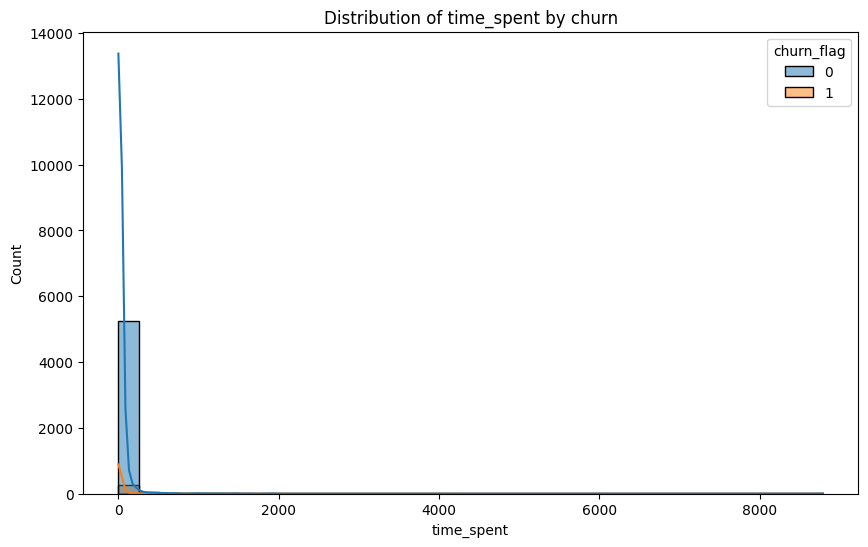

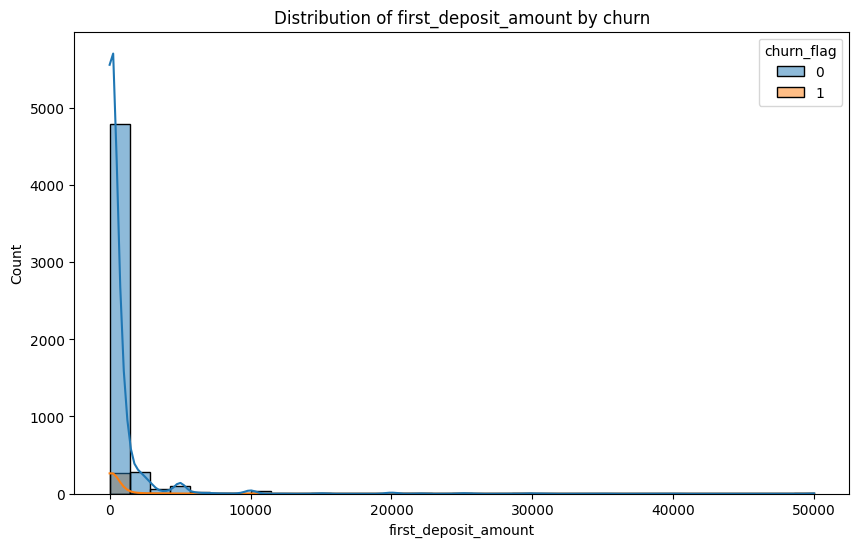

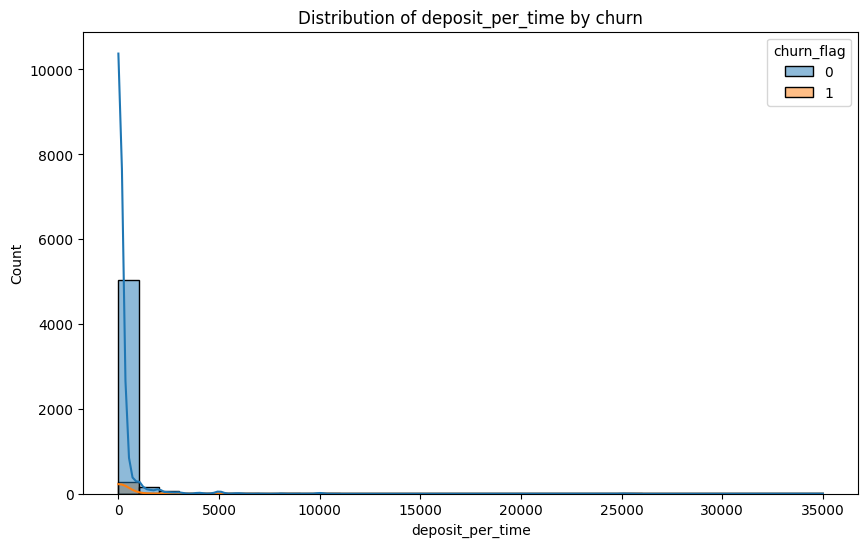

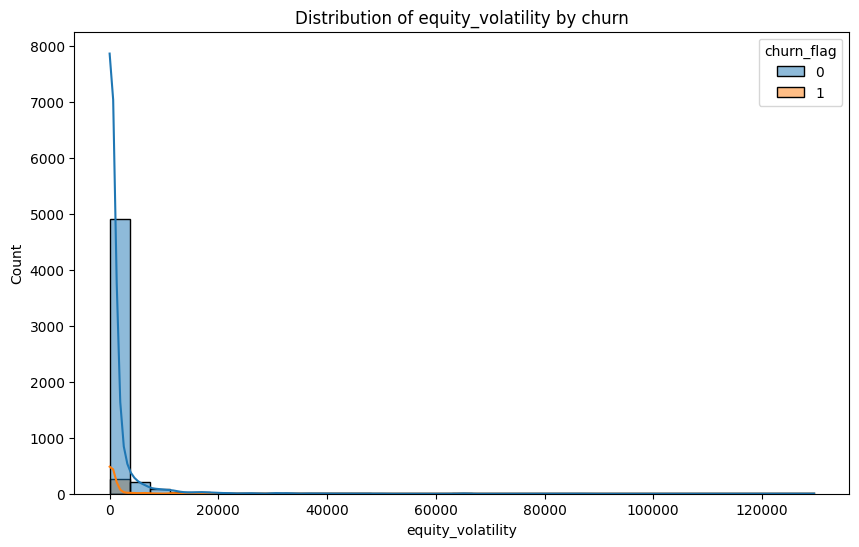

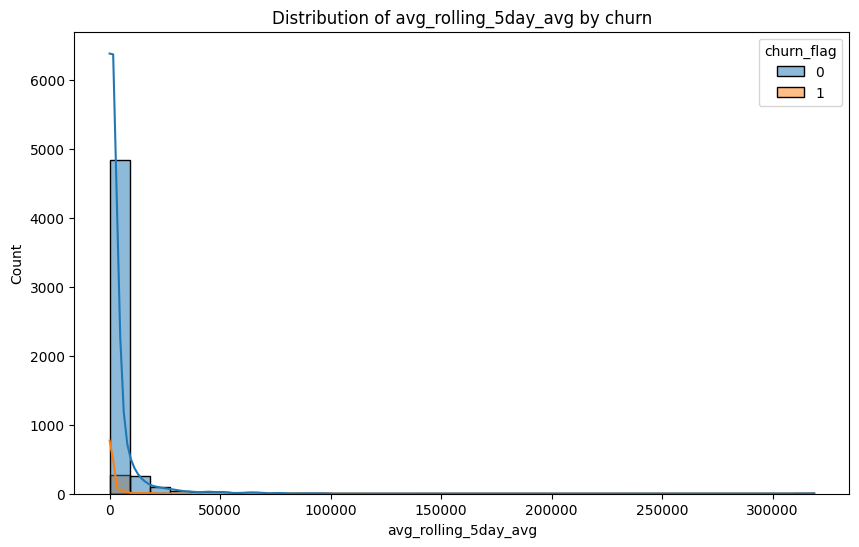

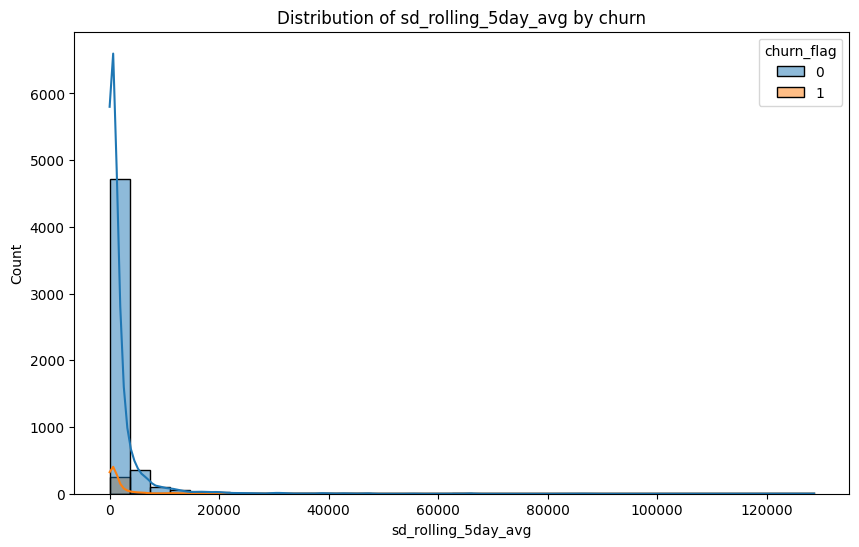

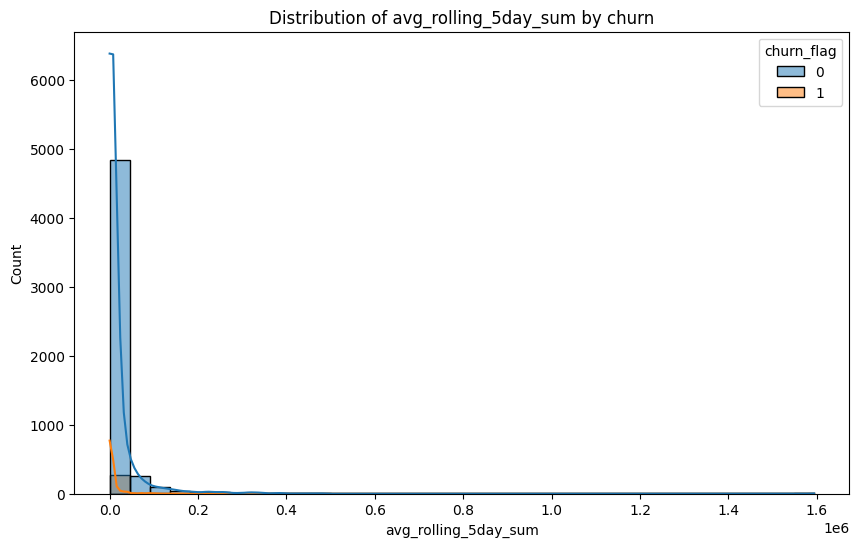

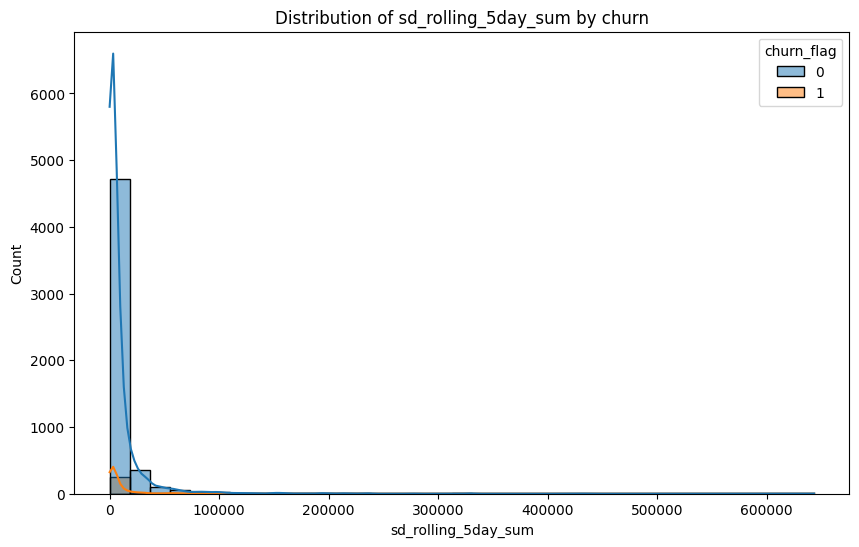

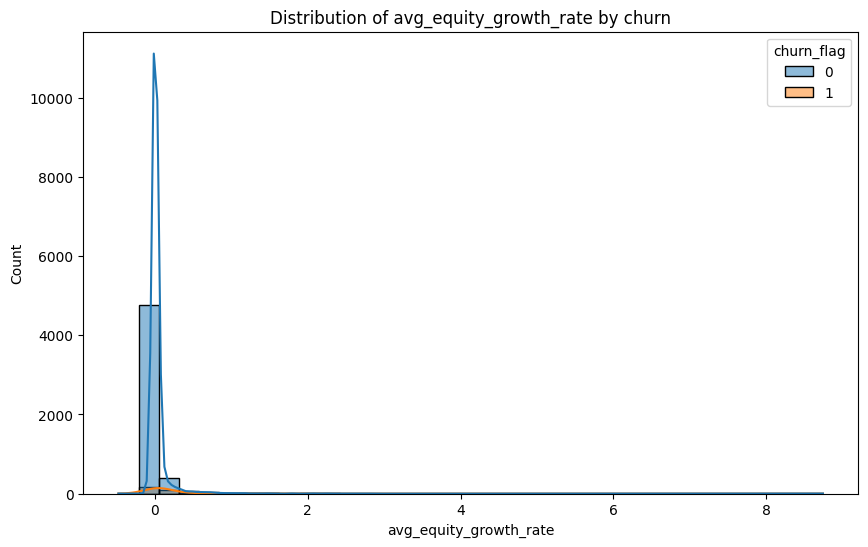

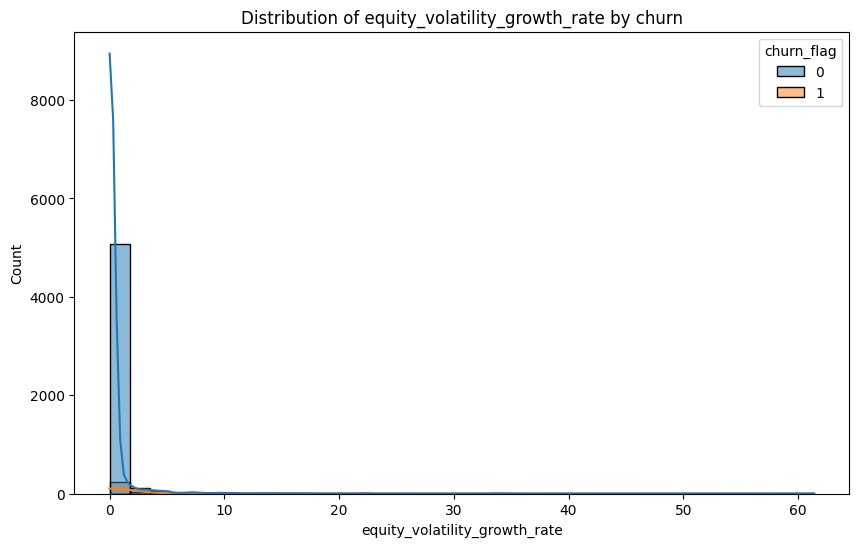

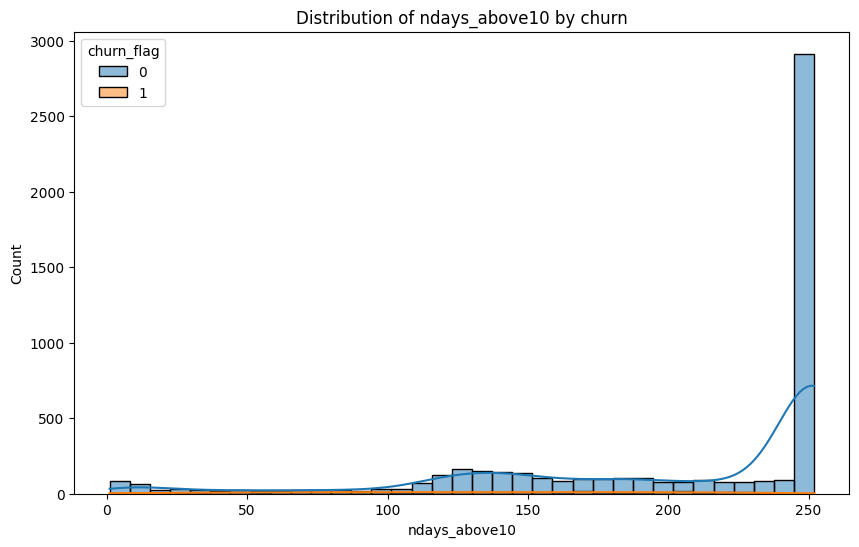

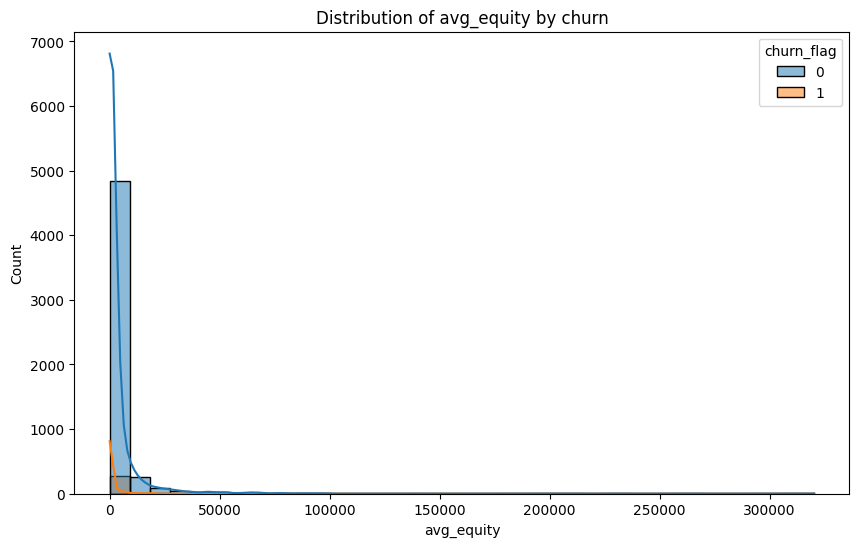

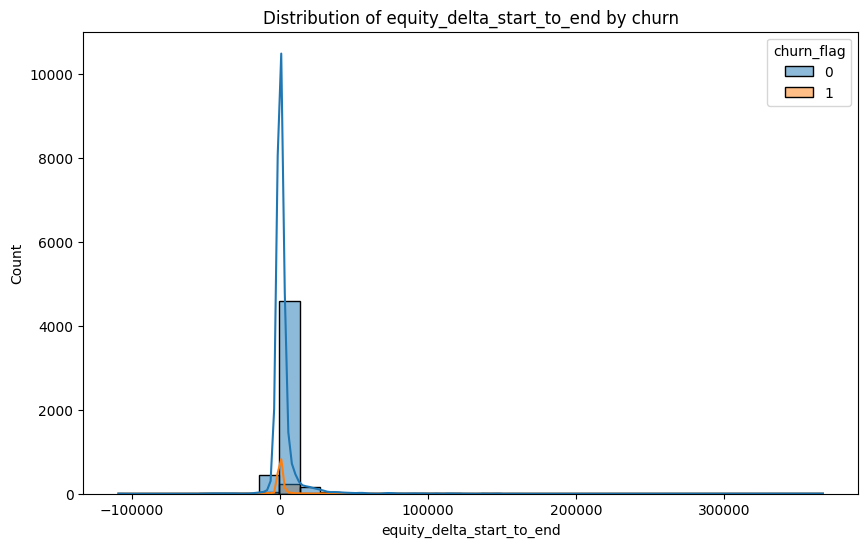

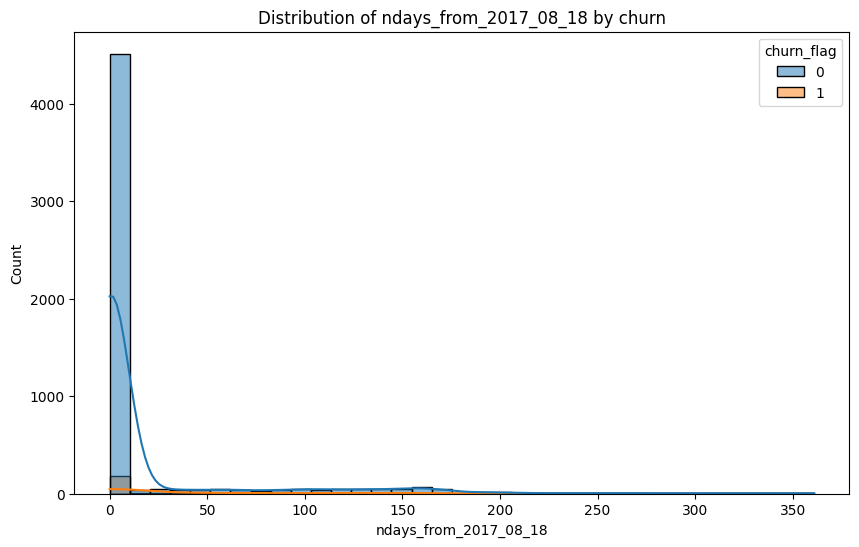

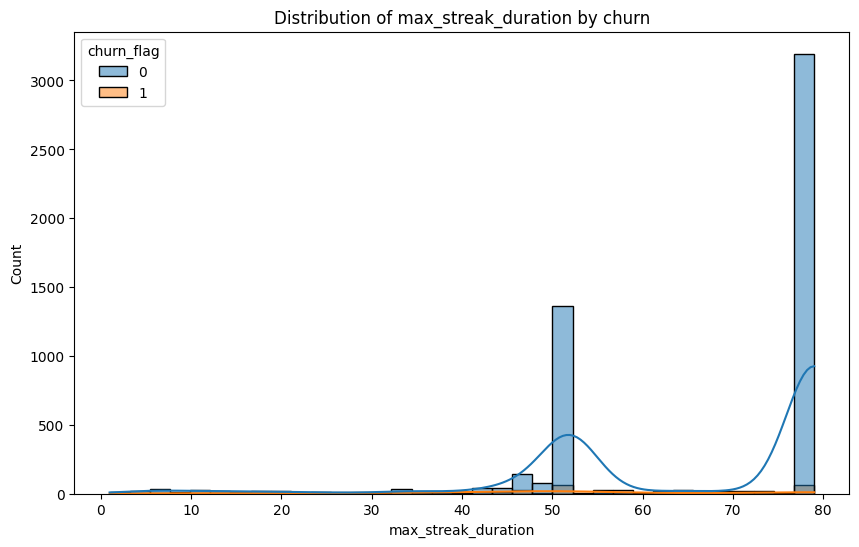

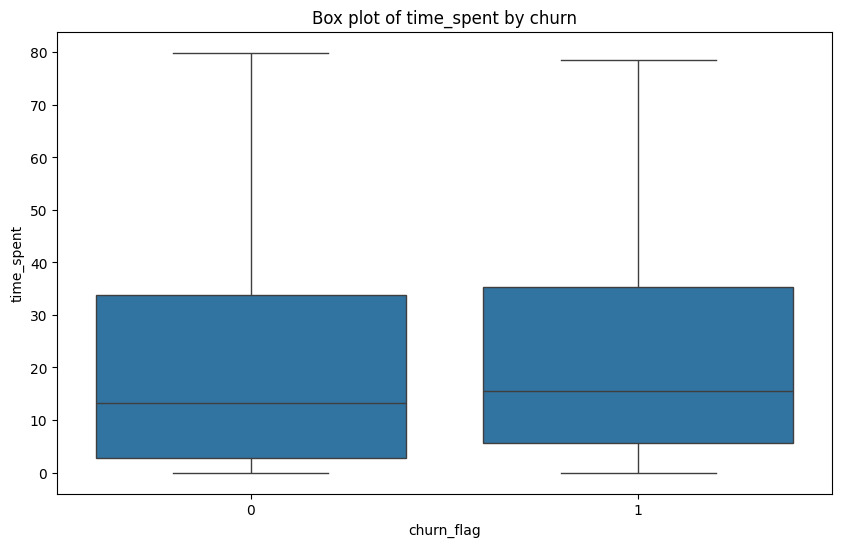

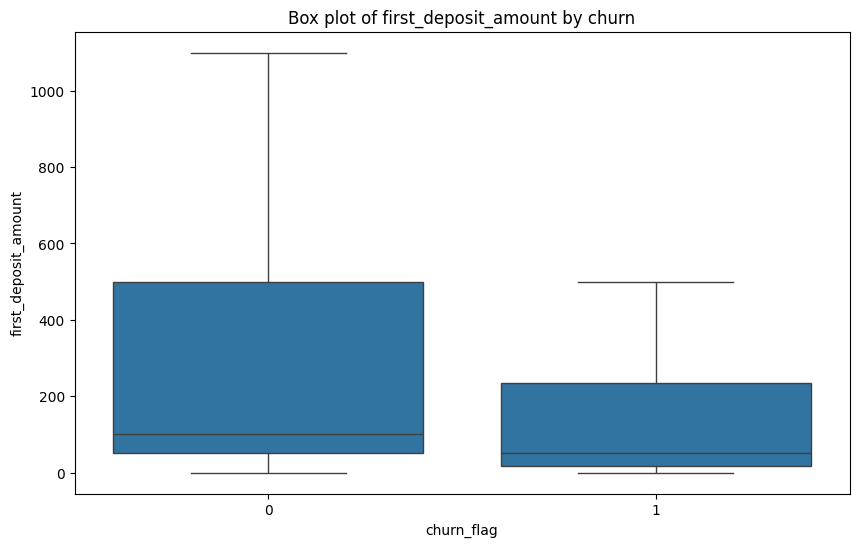

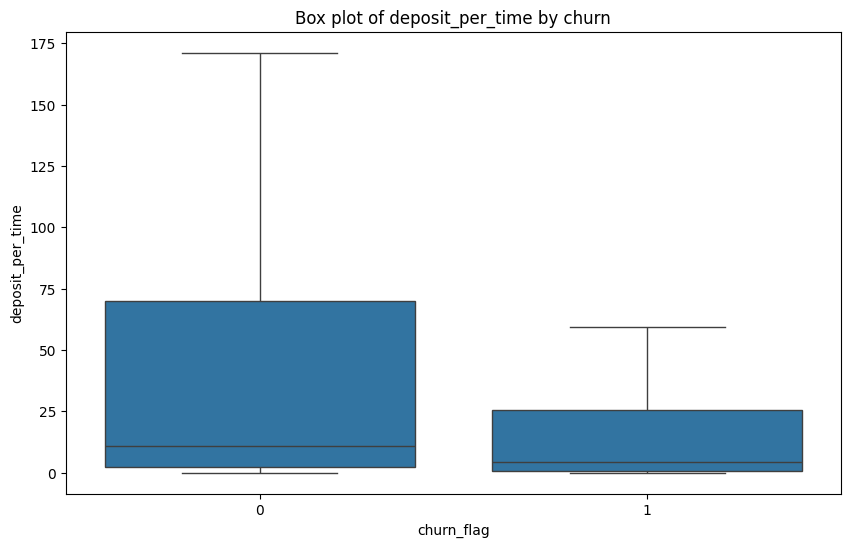

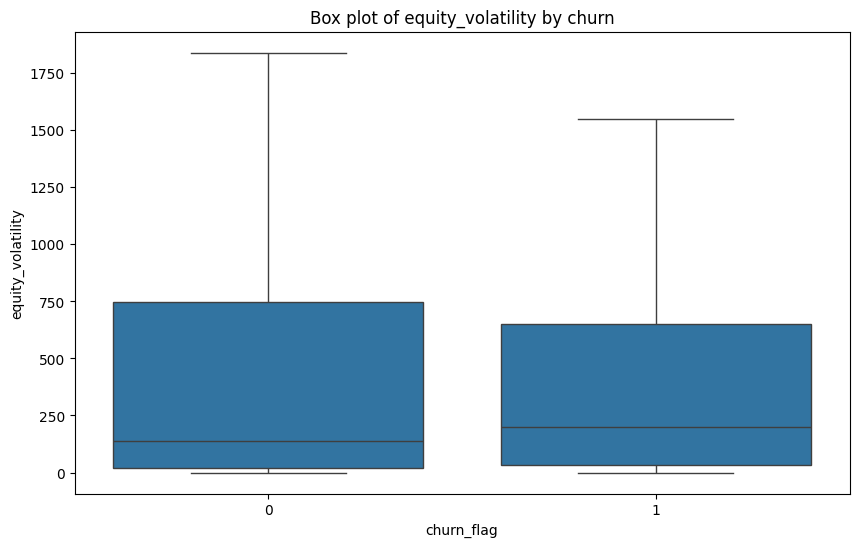

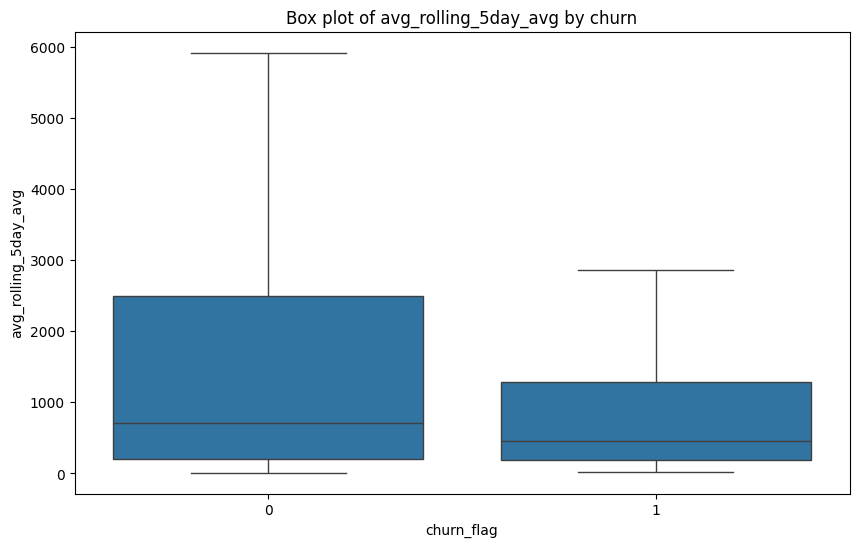

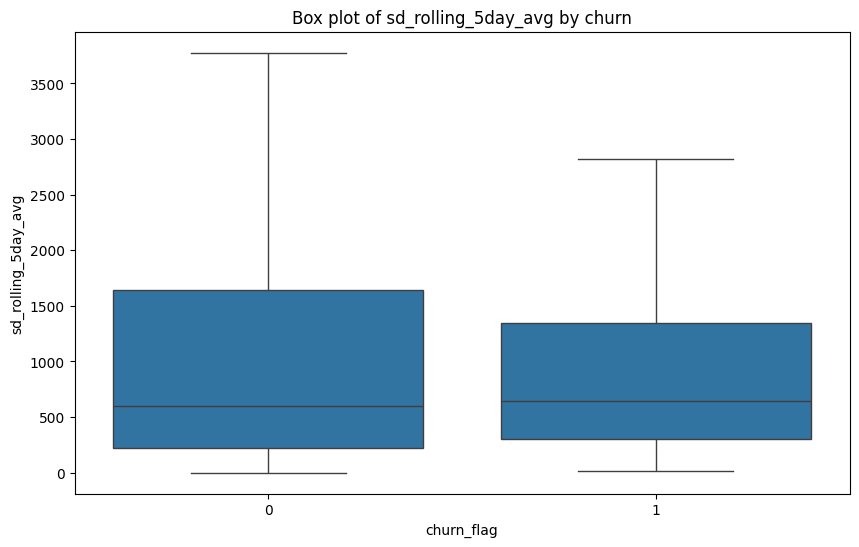

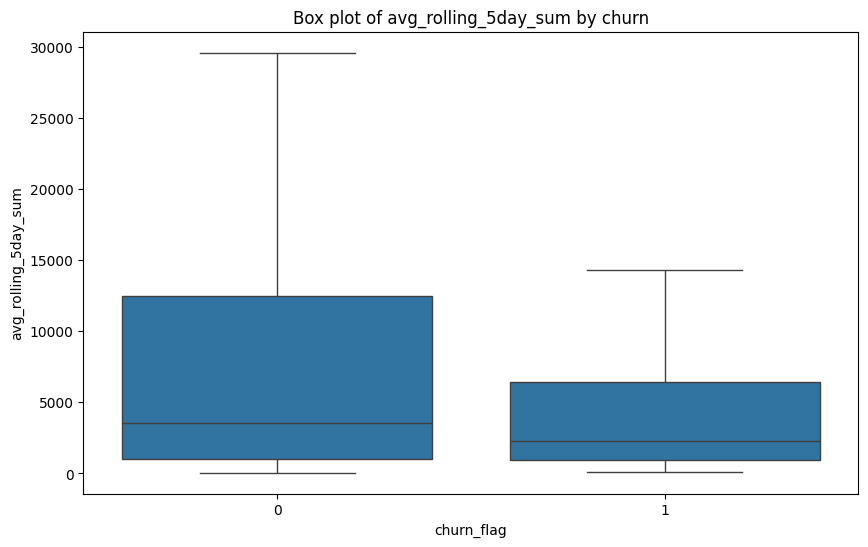

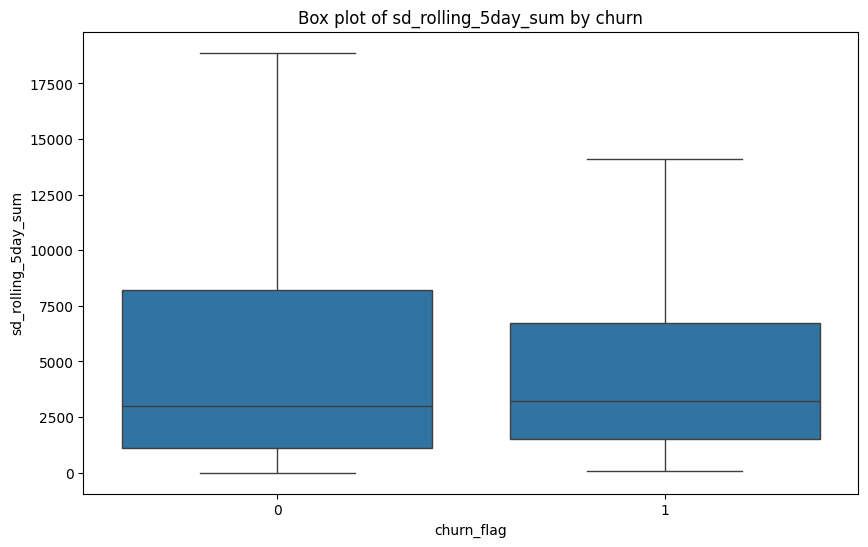

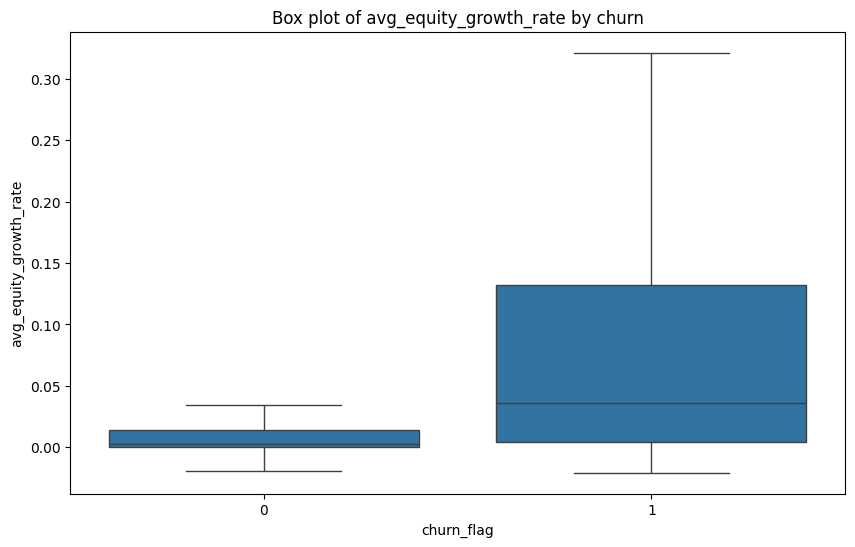

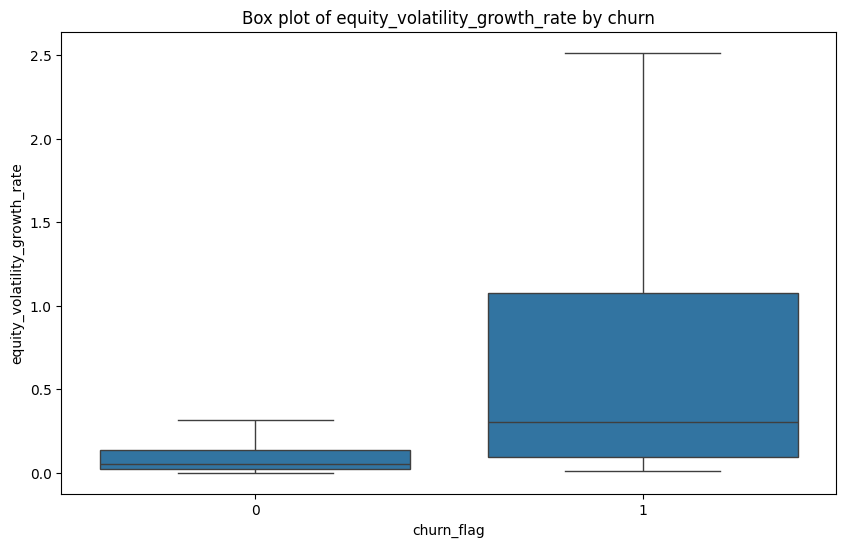

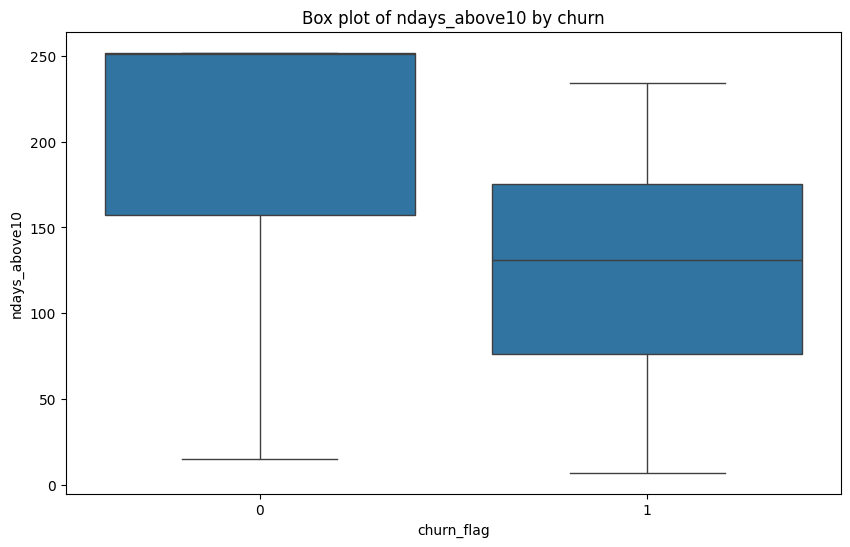

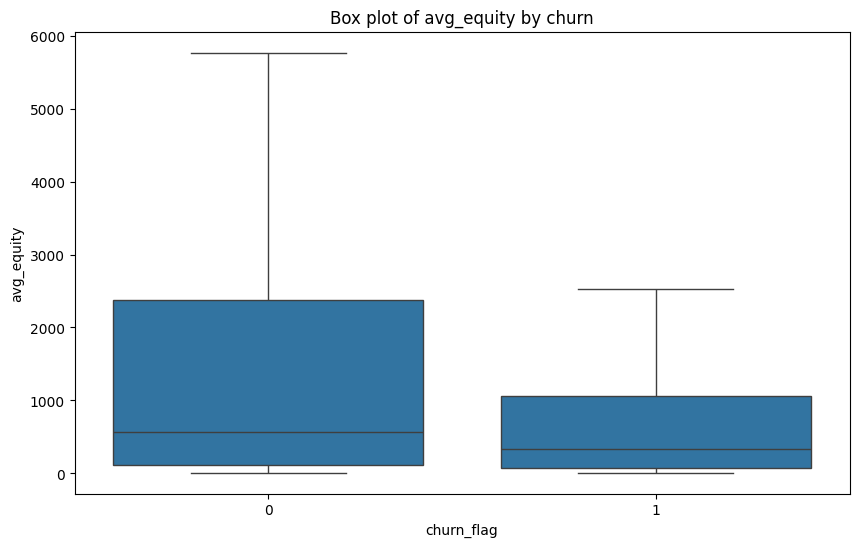

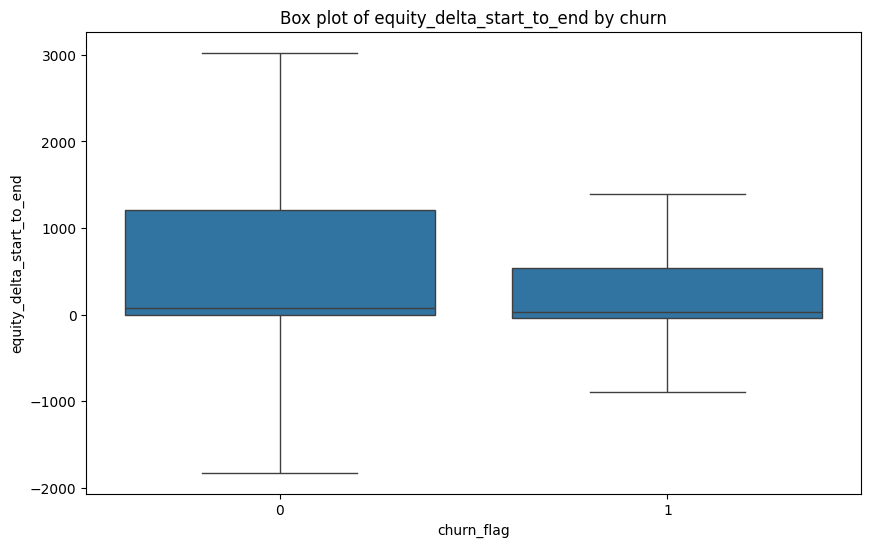

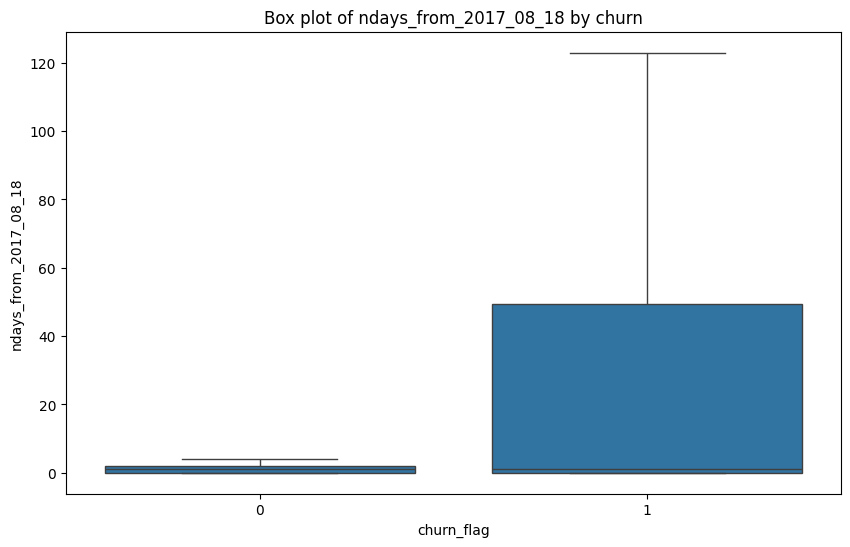

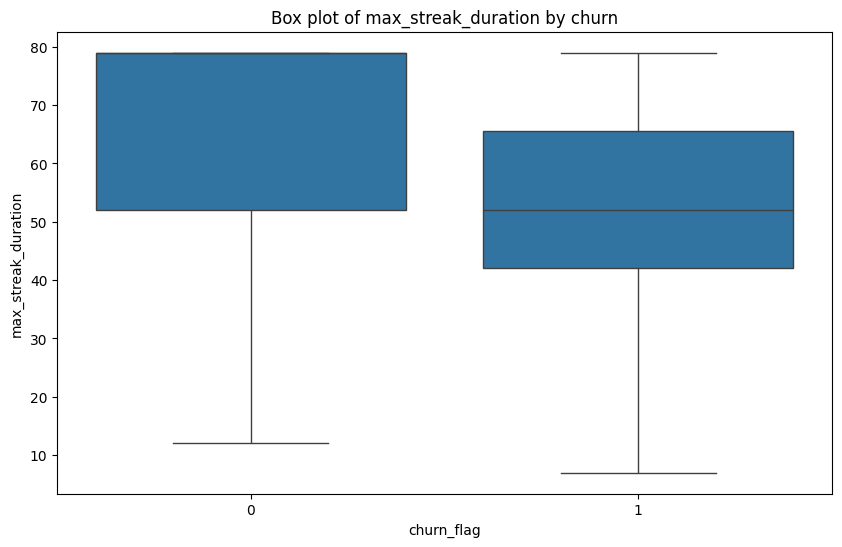

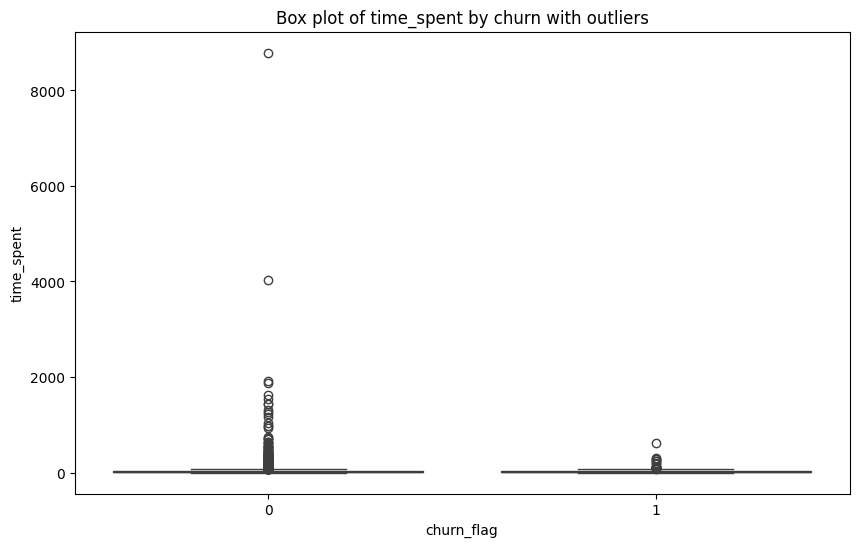

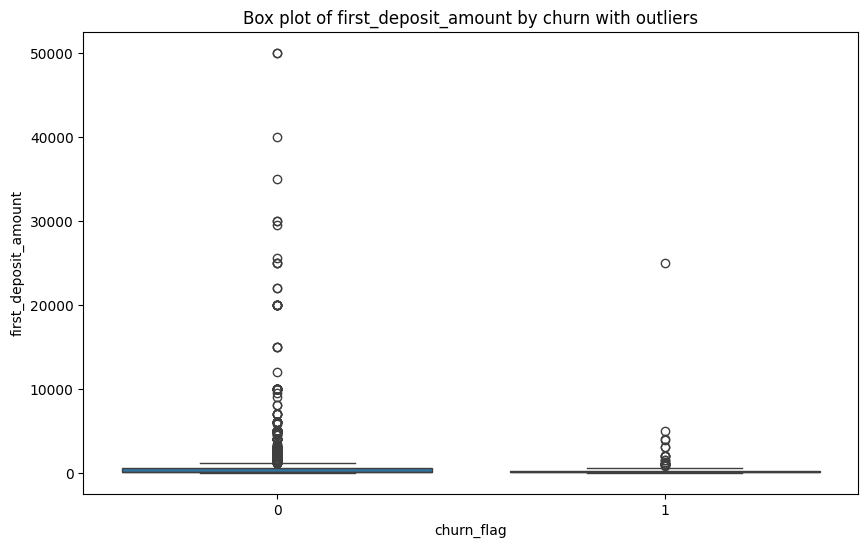

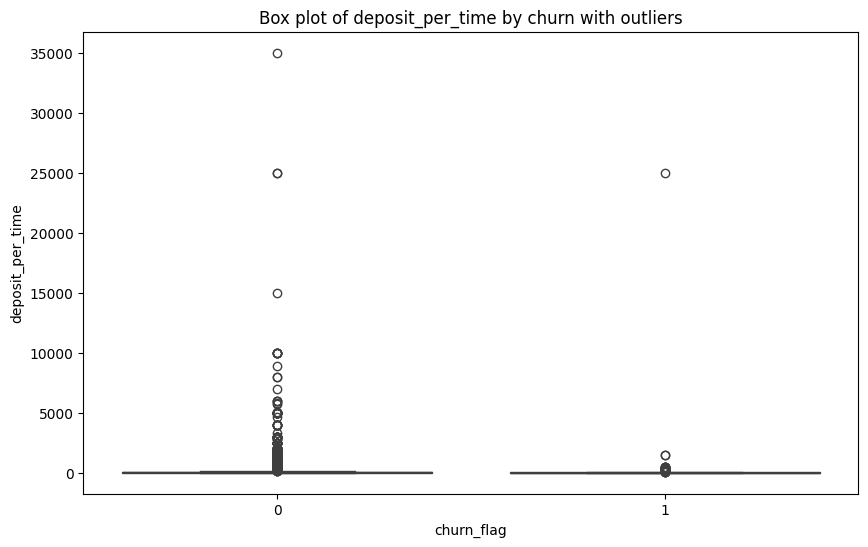

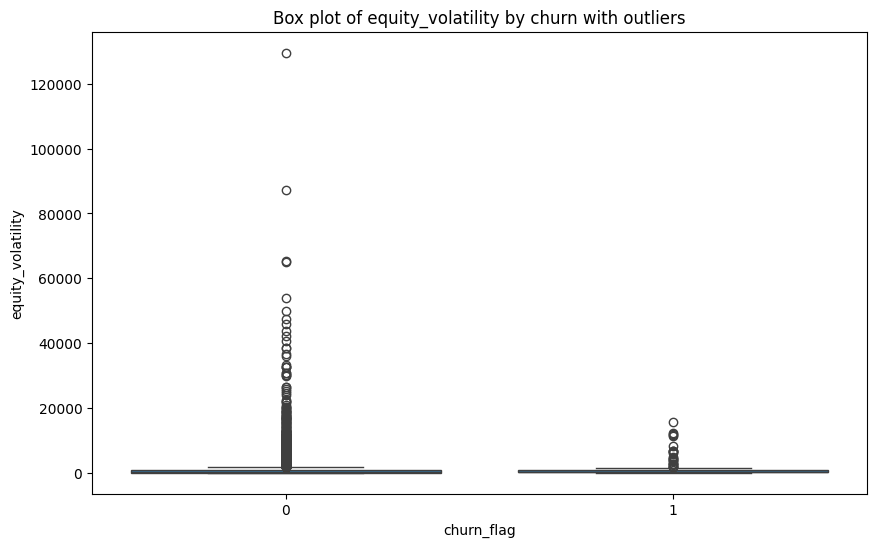

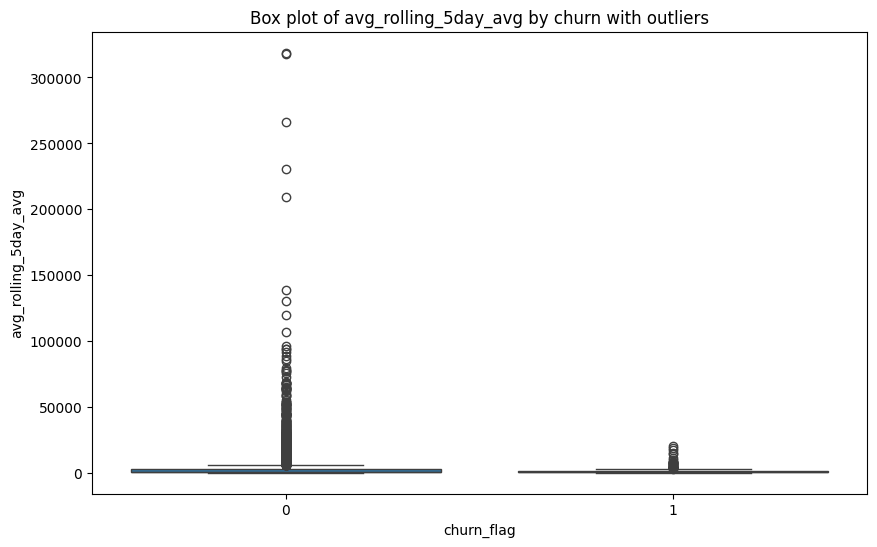

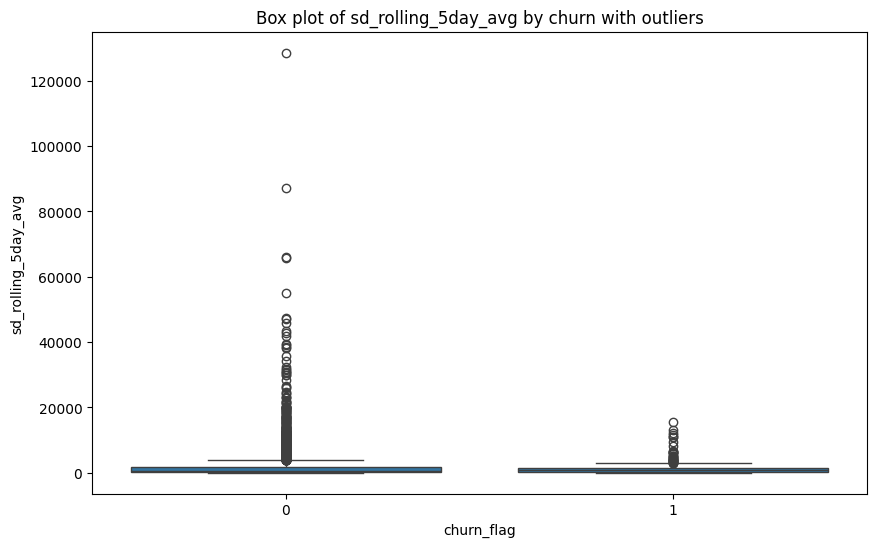

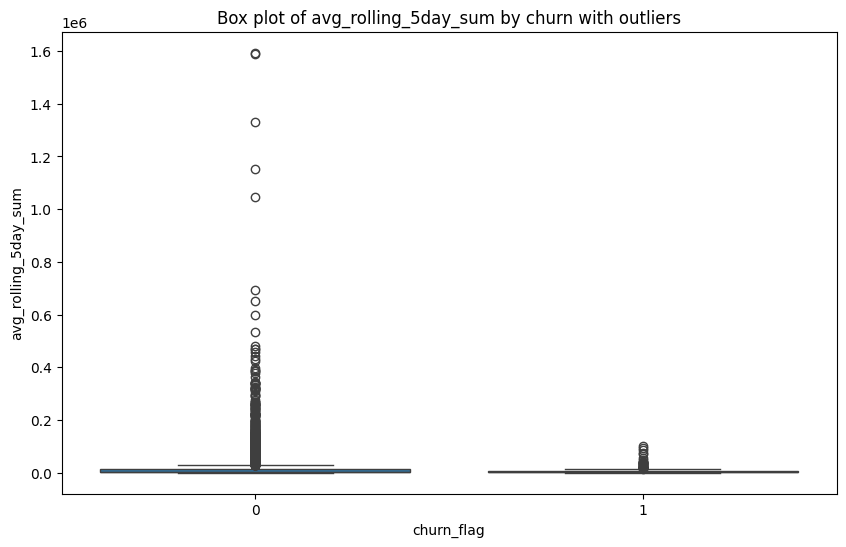

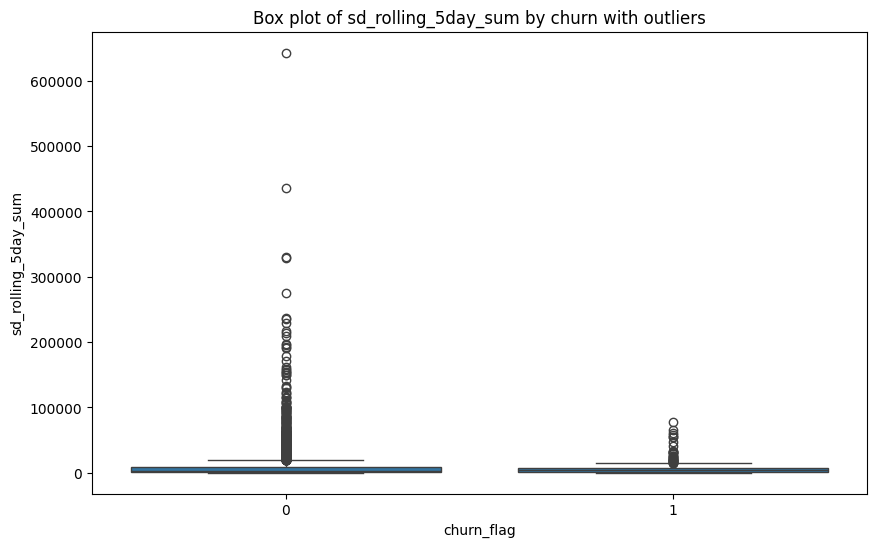

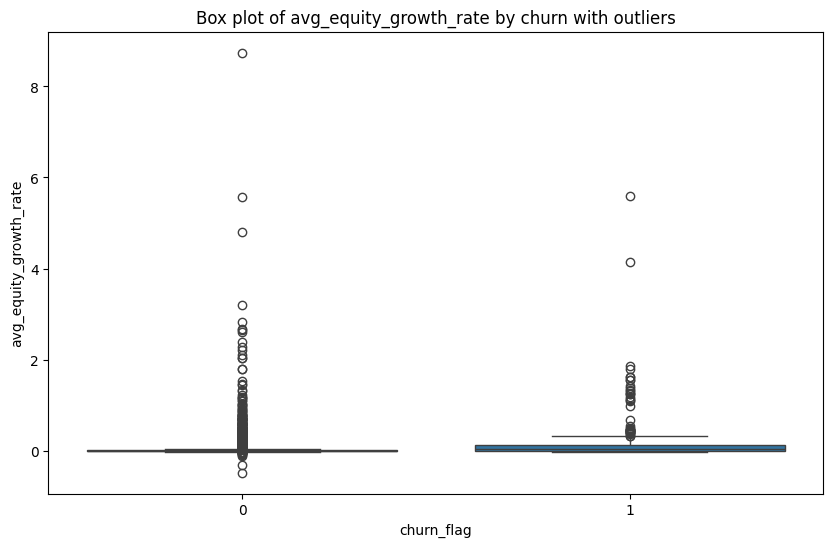

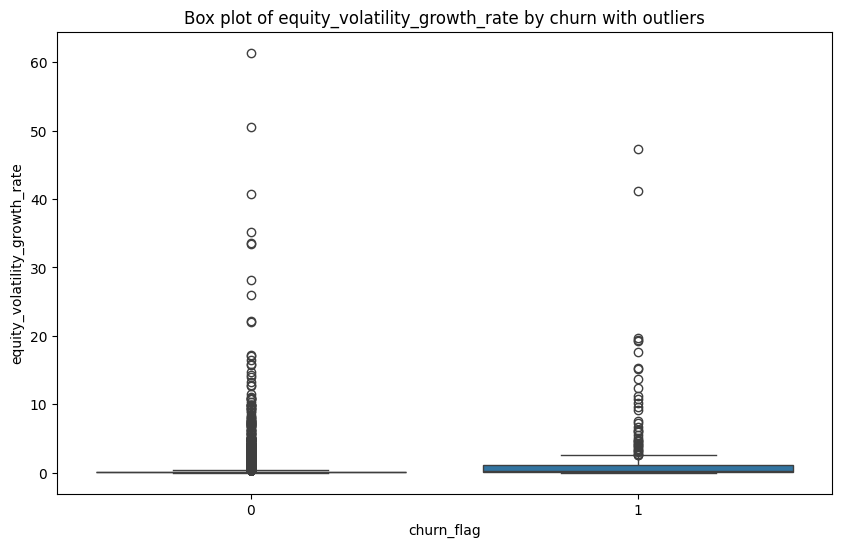

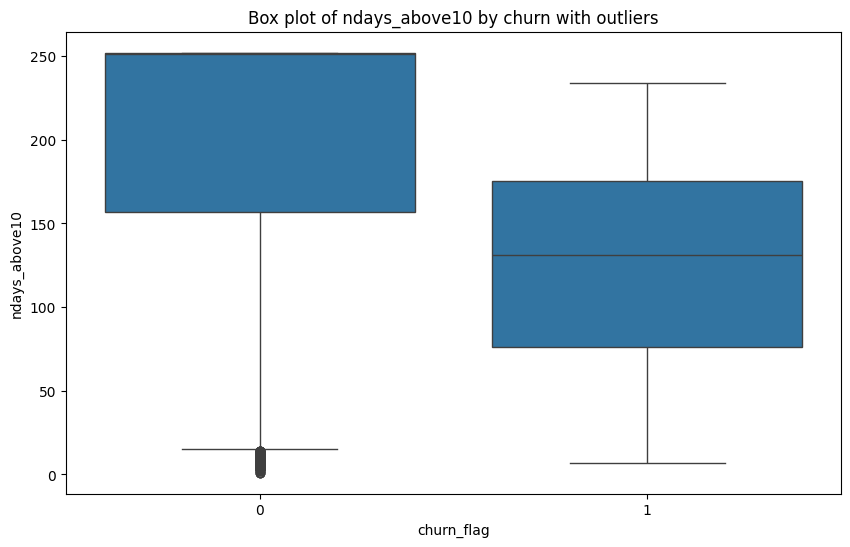

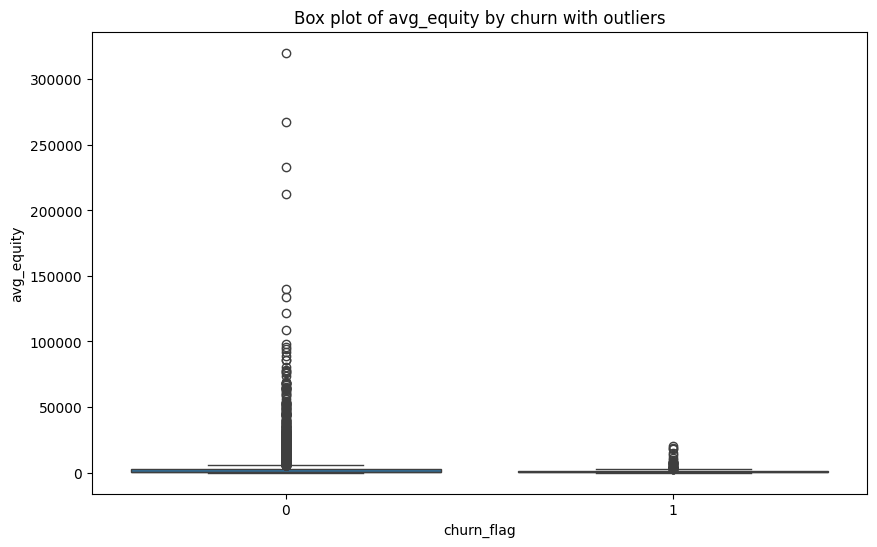

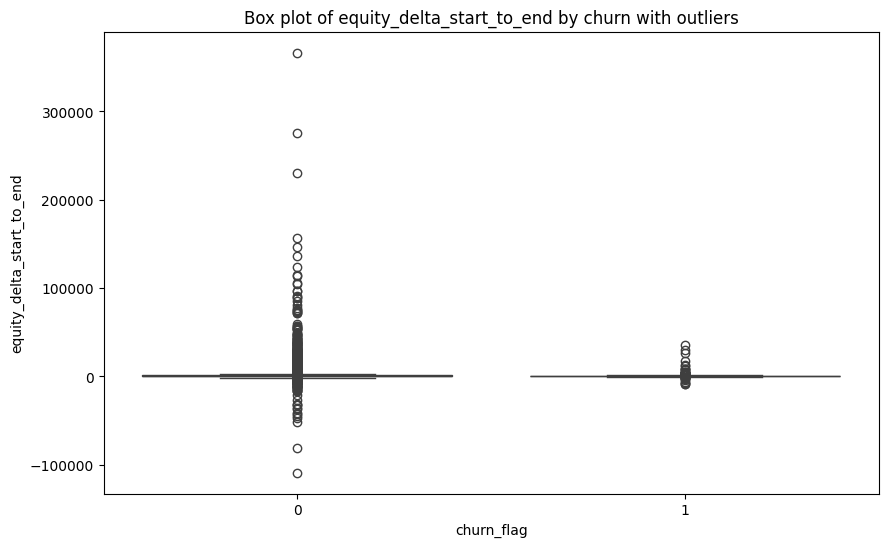

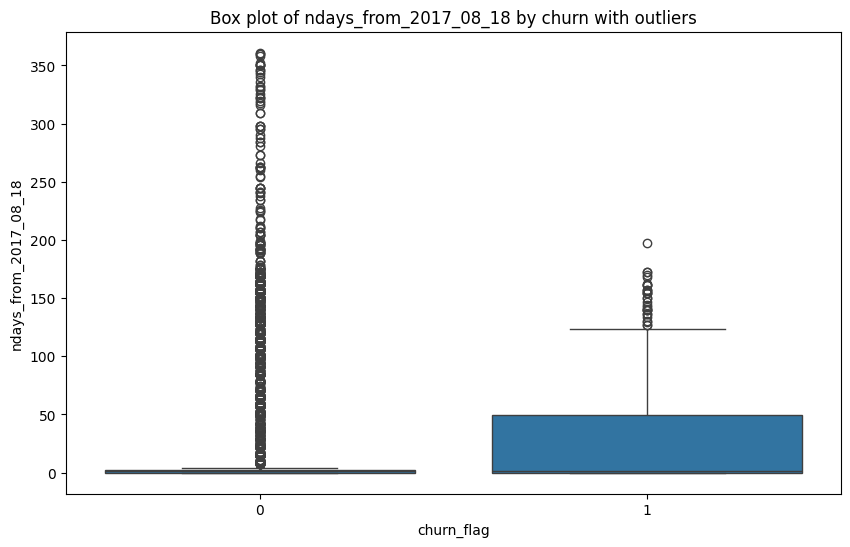

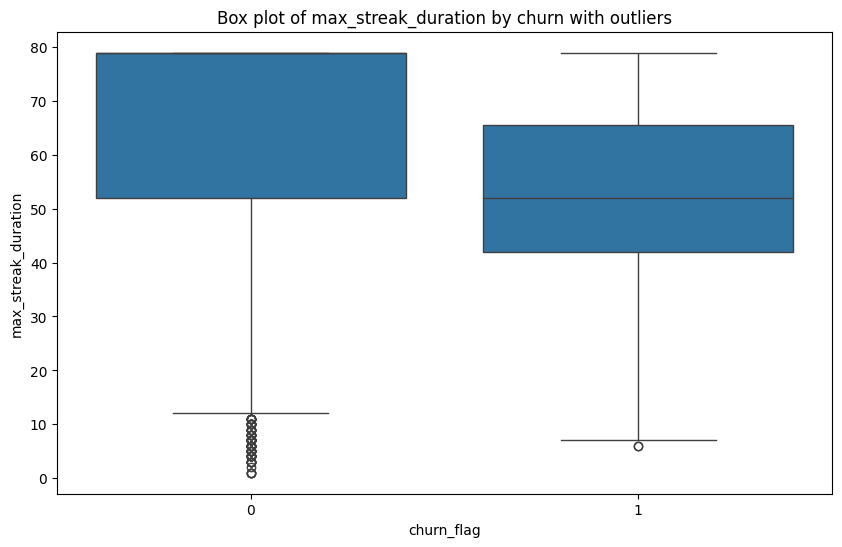

In [61]:
# Distribution plot for numerical features with hue
# Number of bins= n^1/2
# Rice Rule = 2 *ｎ^1/3
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x=col, hue='churn_flag', kde=True, bins=int(2 * len(df)**(1/3)))
    plt.title(f'Distribution of {col} by churn')
    plt.tight_layout()
    plt.show()


# Box plot for numerical features
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df, showfliers=False)
    plt.title(f'Box plot of {col} by churn')
    plt.tight_layout()
    plt.show()

# Box plot for numerical features to detect outliers
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df)
    plt.title(f'Box plot of {col} by churn with outliers')
    plt.tight_layout()
    plt.show()

### Univariate Analysis | Categorical Features: Frequency distributions

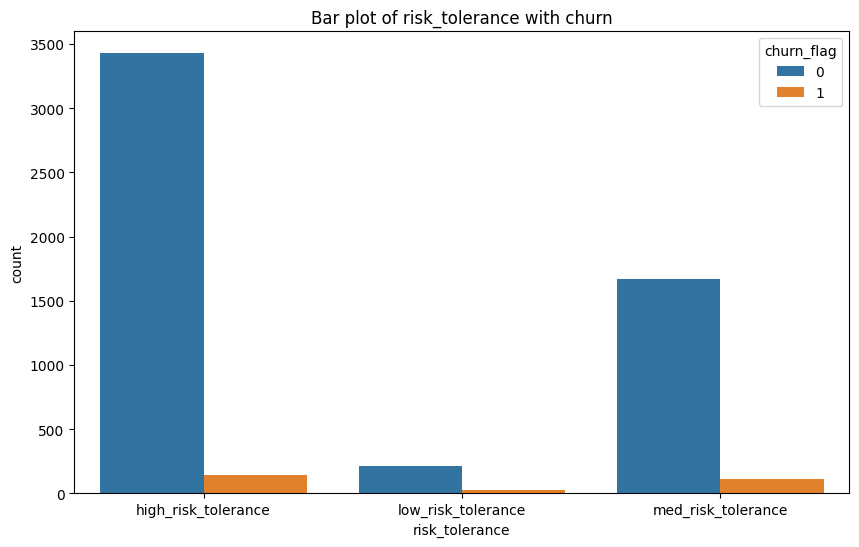

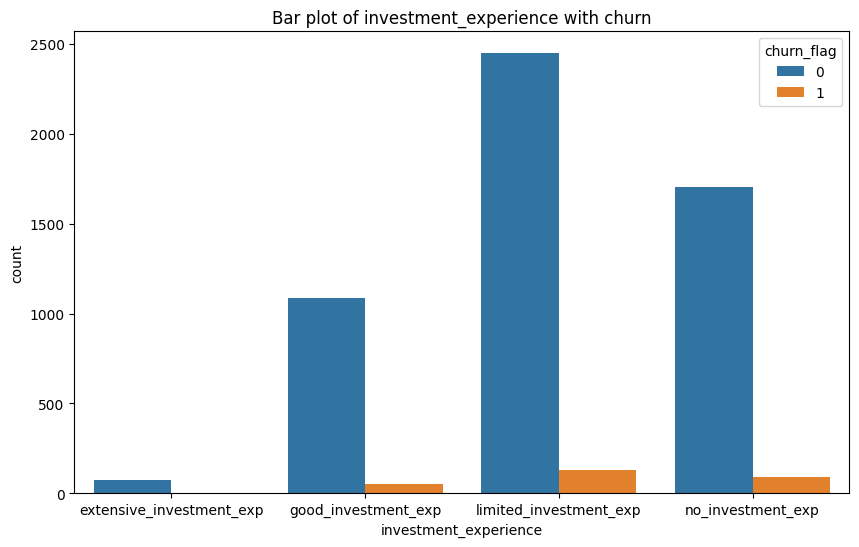

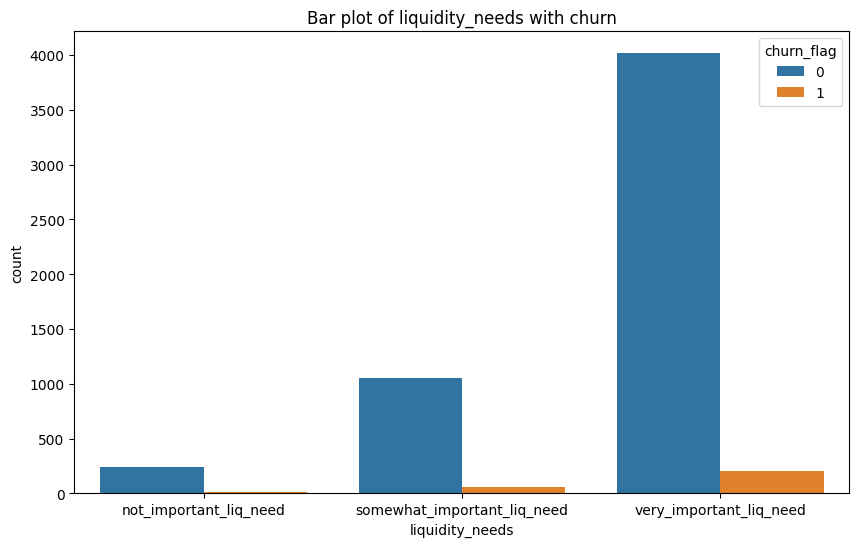

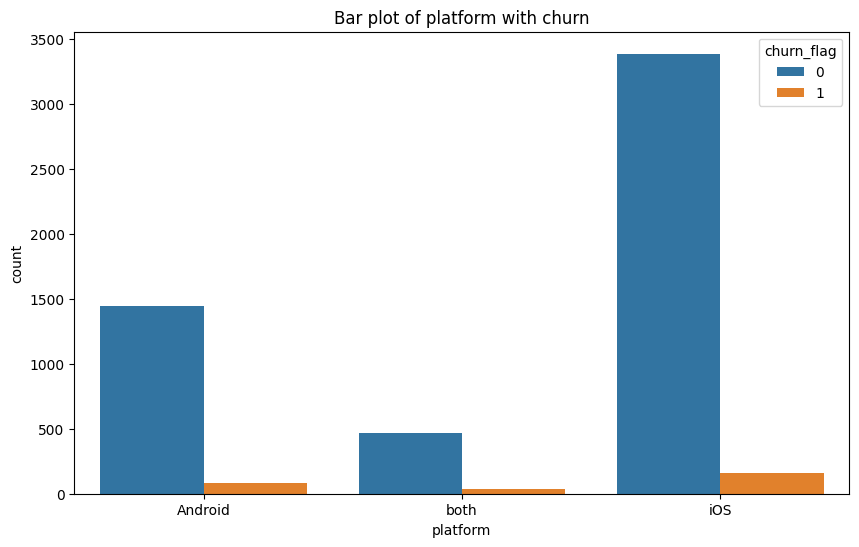

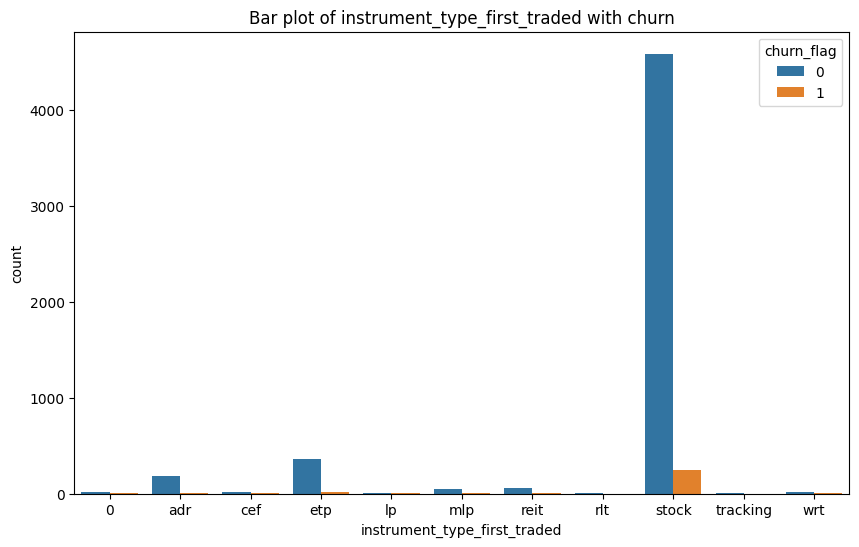

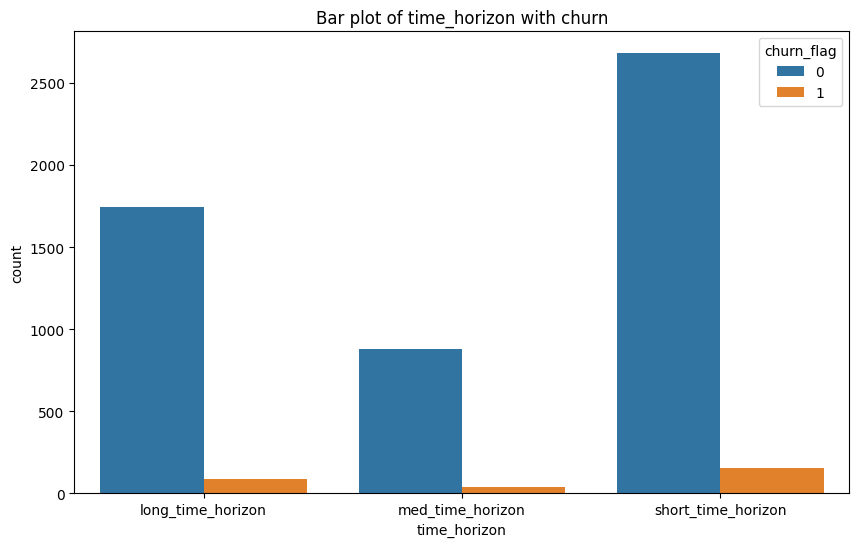

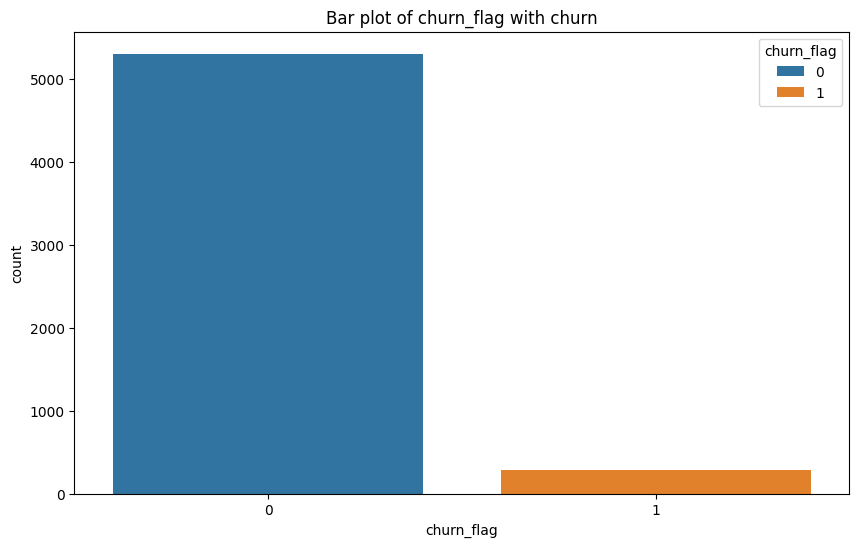

In [62]:
# Bar plot for categorical features
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, hue='churn_flag')
    plt.title(f'Bar plot of {col} with churn')
    plt.show()

### Multivariate Analysis | Interactions and Correlations

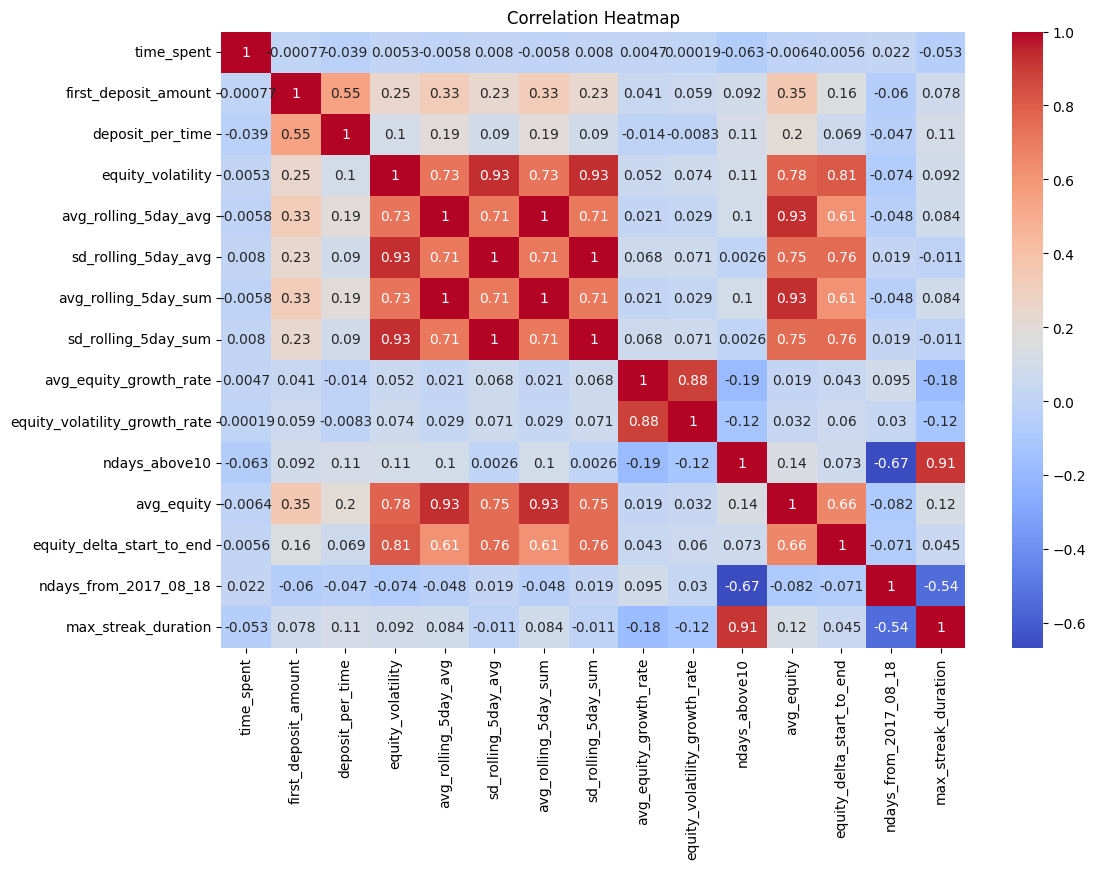

In [63]:
# Correlation matrix and heatmap to understand relationships between numerical variables.
# Filter out only numerical columns
num_cols_temp = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix and heatmap to understand relationships between numerical variables.
plt.figure(figsize=(12, 8))
corr = num_cols_temp.corr()  # Calculate correlation on numerical columns
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

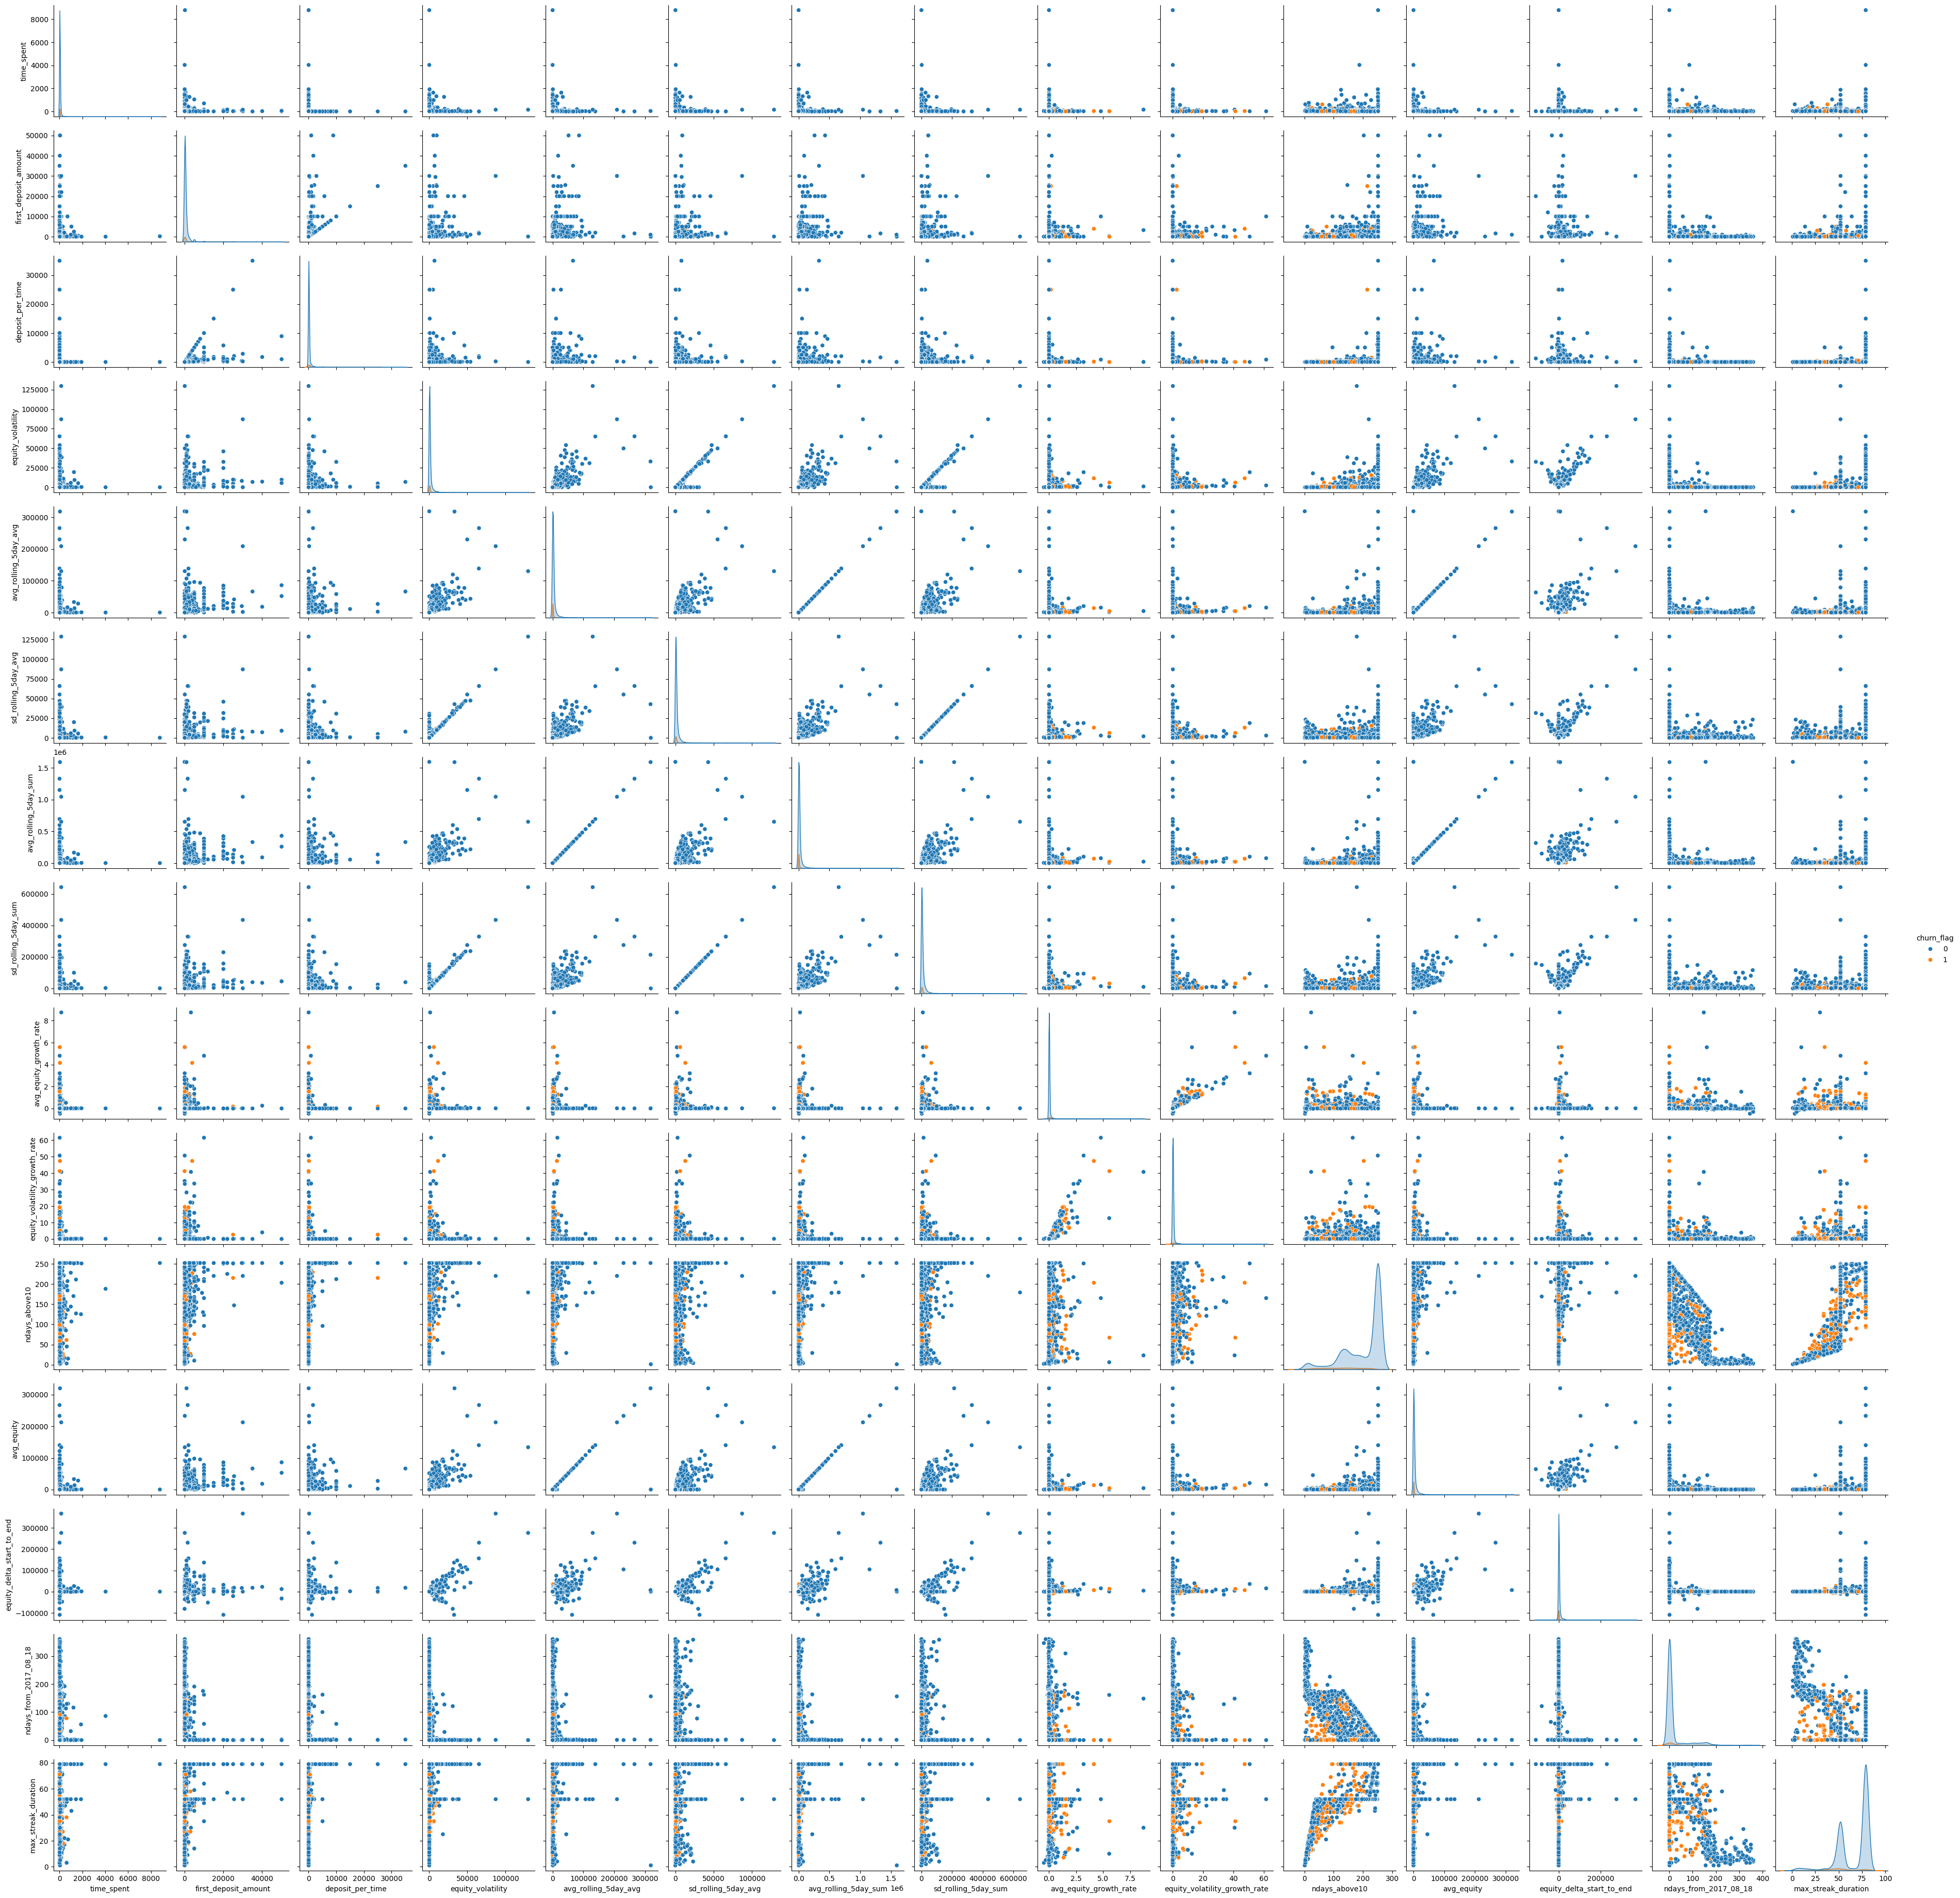

In [64]:
# Pair plot to see pairwise relationships
sns.pairplot(df, hue='churn_flag', vars=num_cols)
plt.show()

### Understanding Distribution Patterns (Normal, Bimodal, Skewed)



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



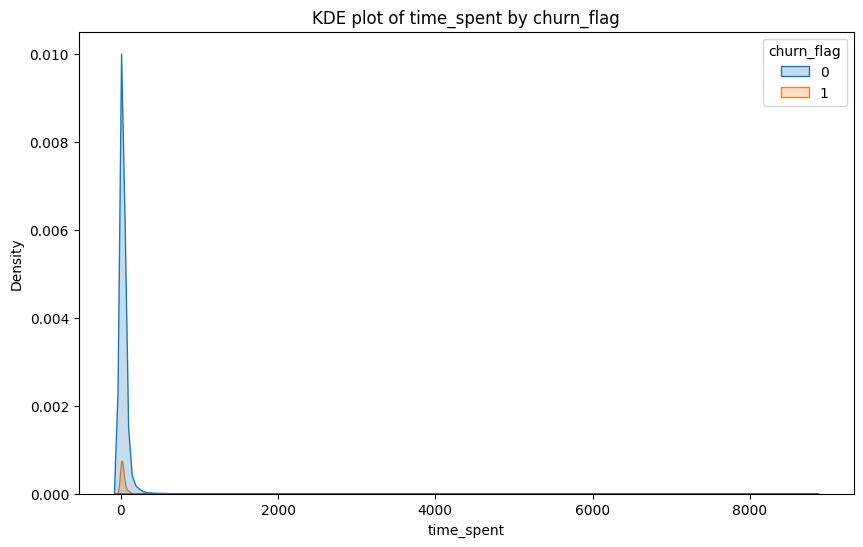



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



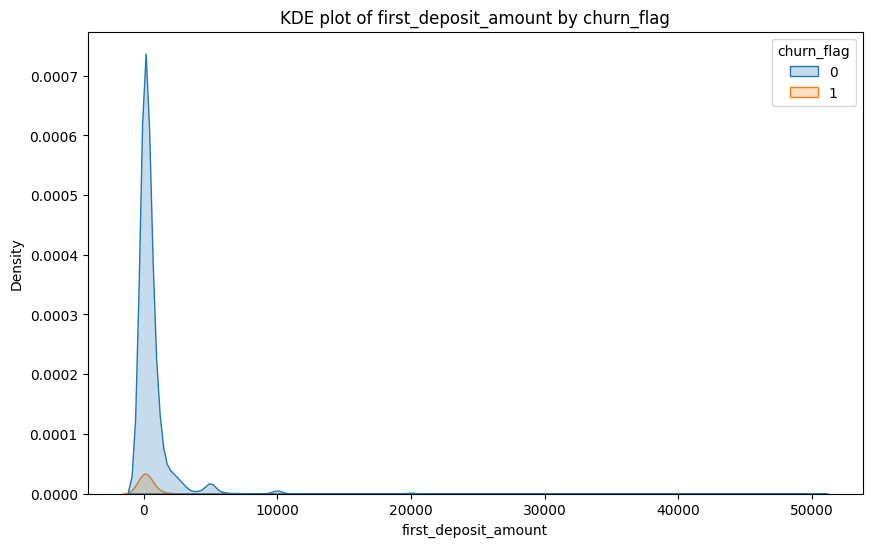



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



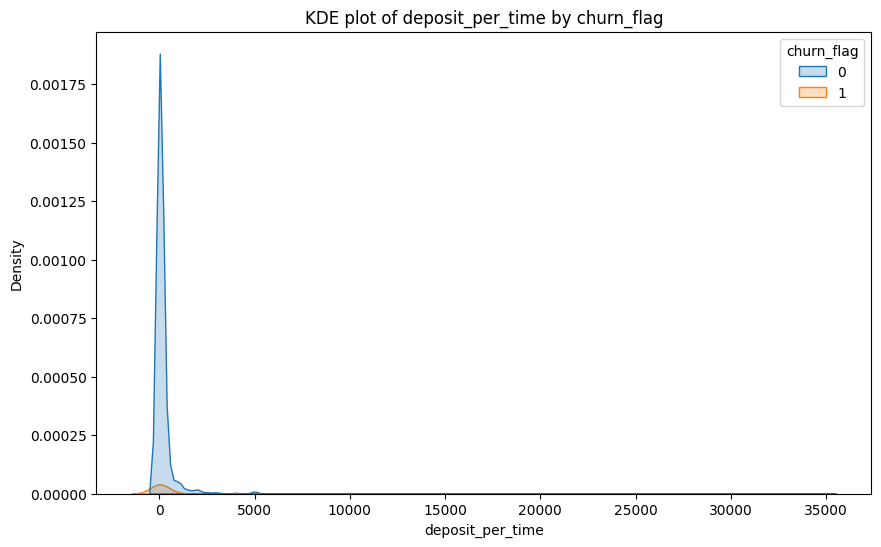



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



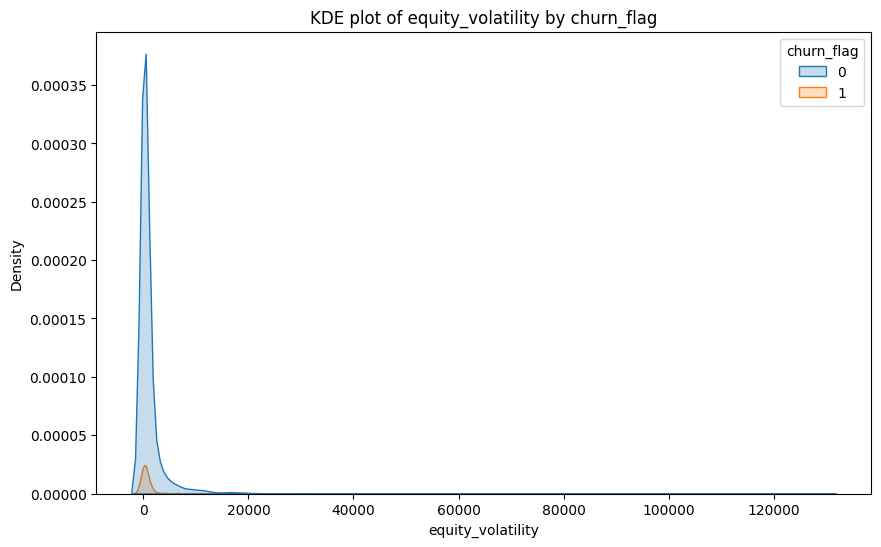



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



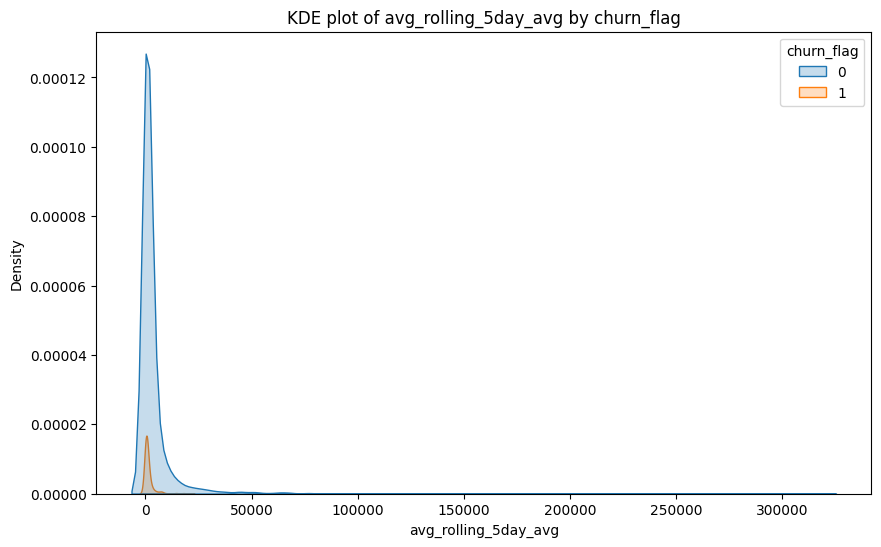



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



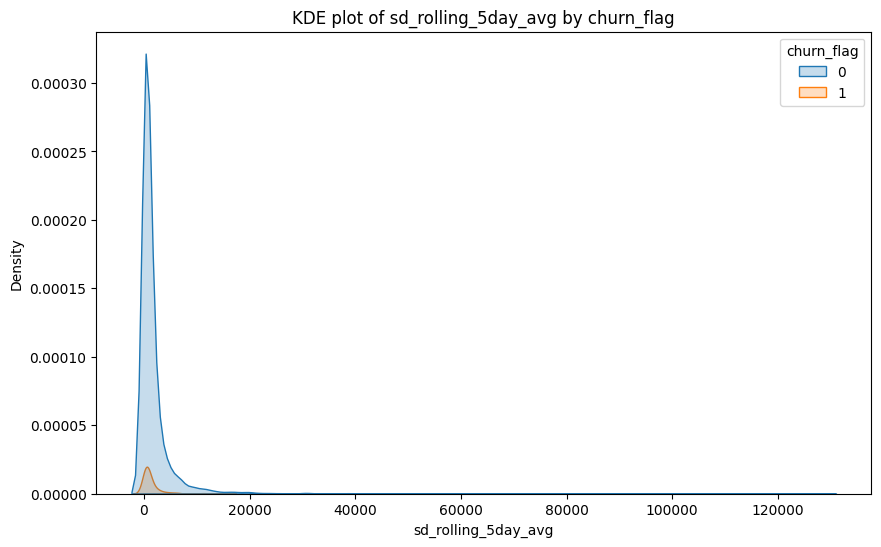



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



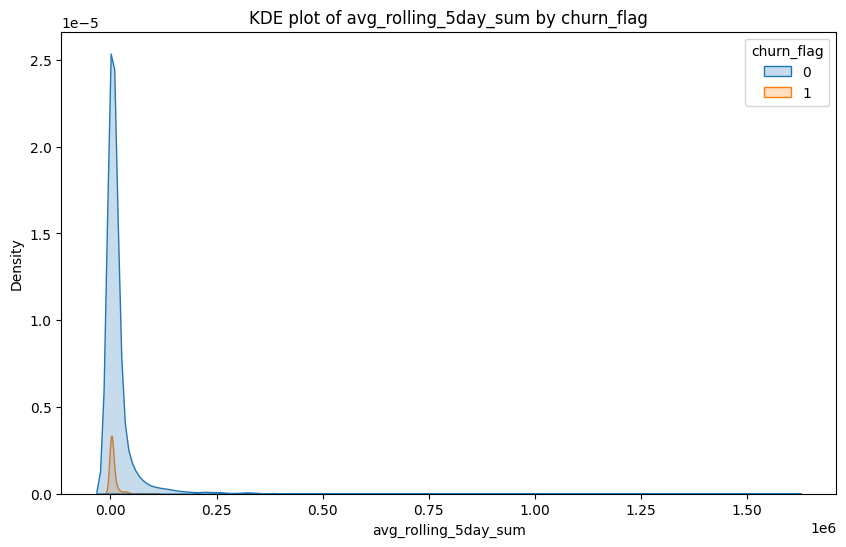



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



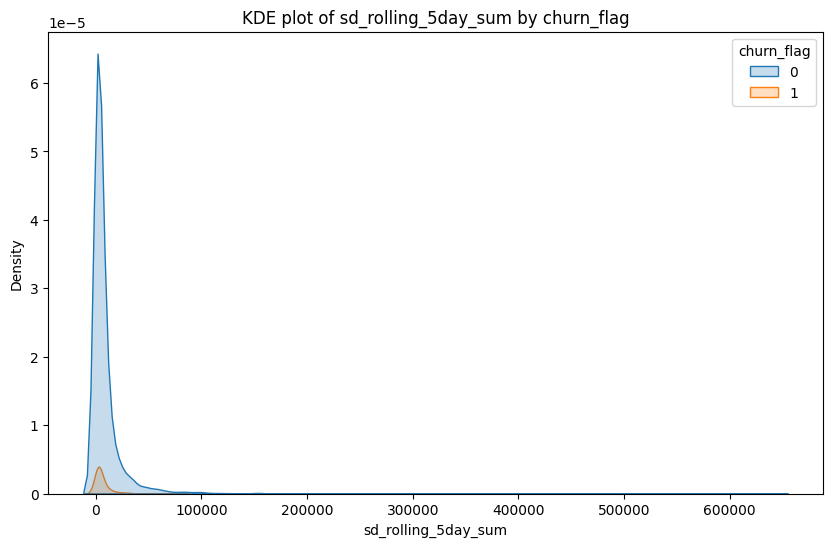



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



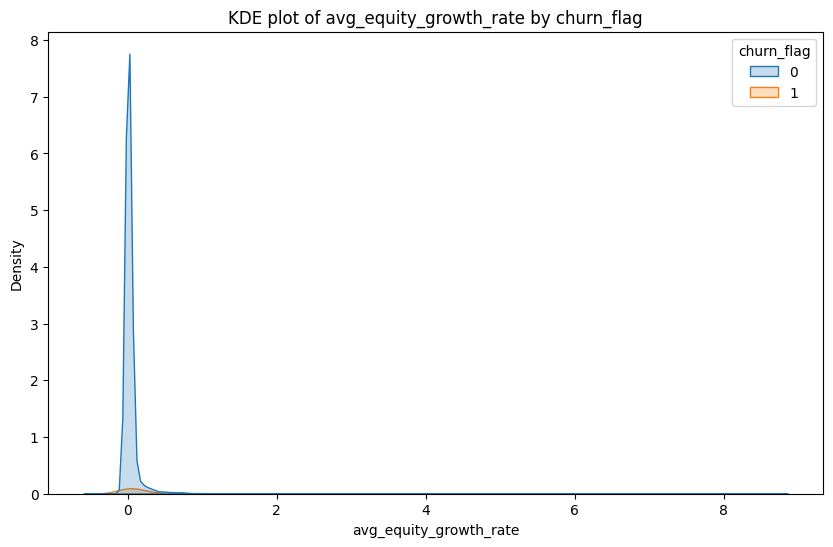



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



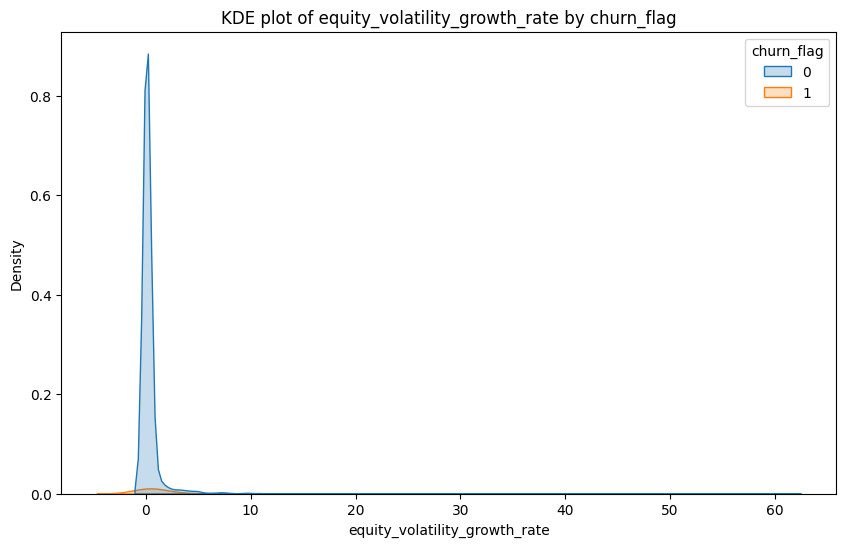



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



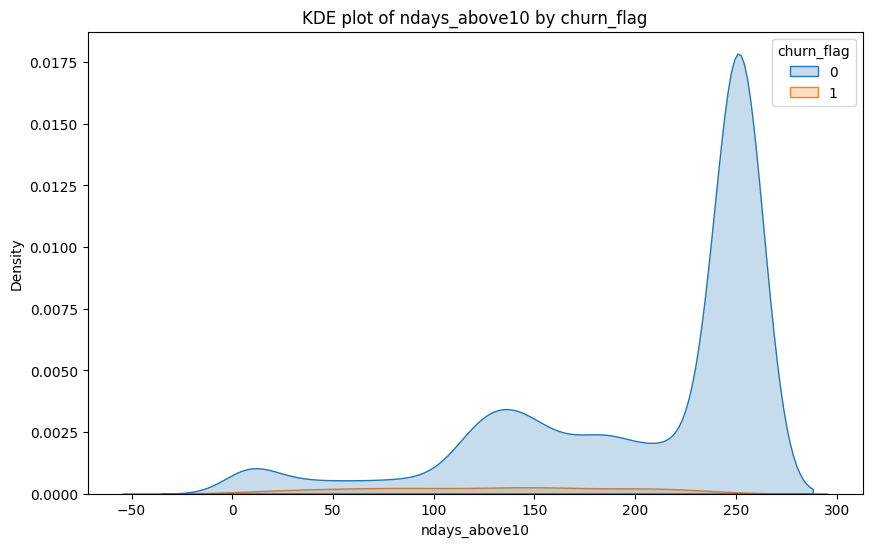



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



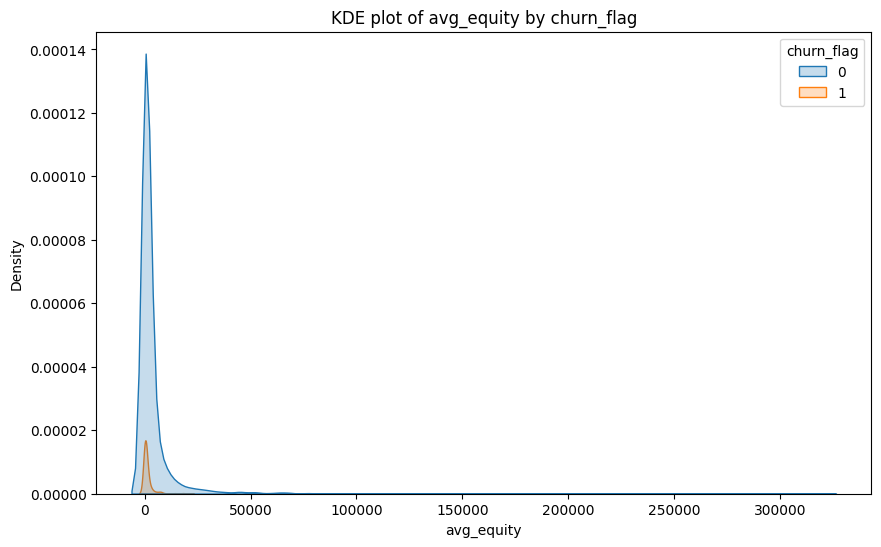



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



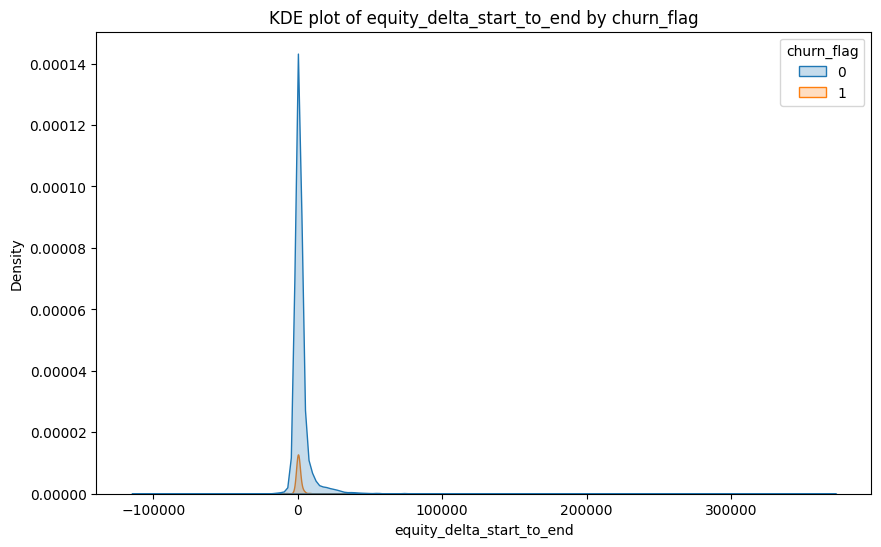



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



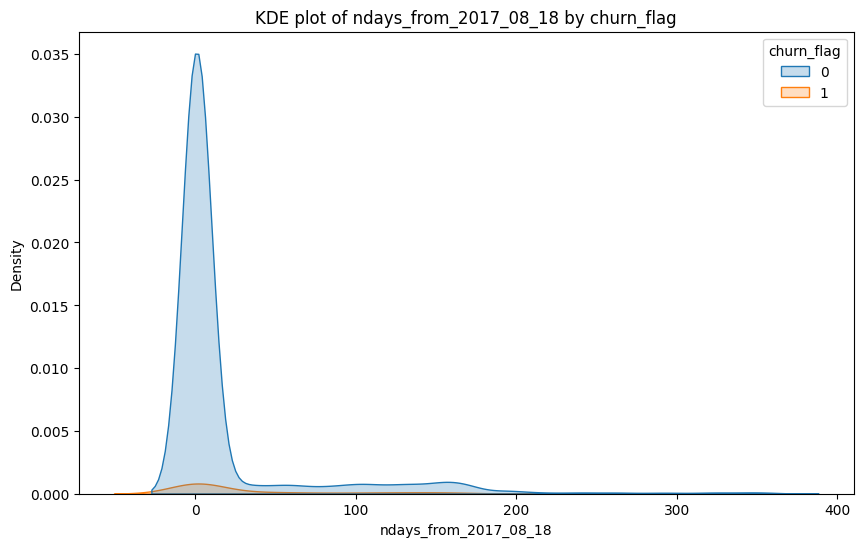



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



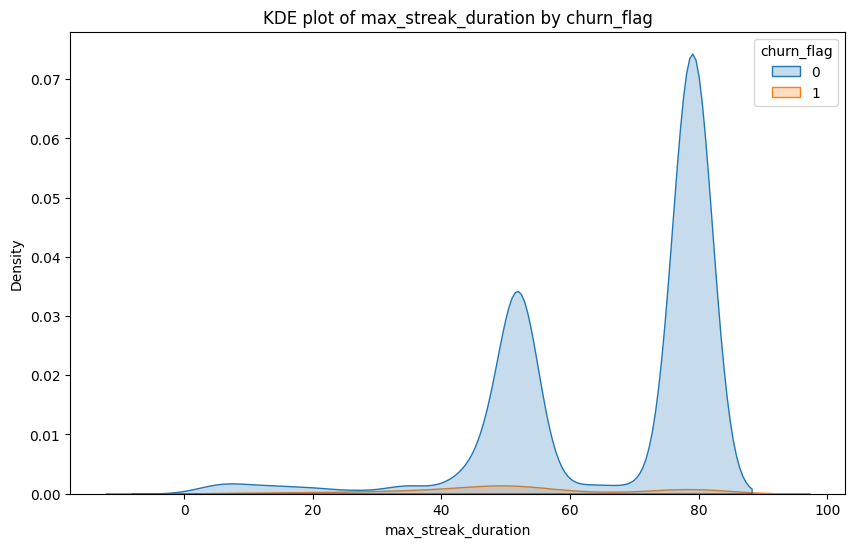

In [65]:
# KDE plot to understand the distribution shape
# Remember 'churn_flag' is treated as categorical since hue parameter needs to be a category
# KDE plot to understand the distribution shape
for col in num_cols:
    plt.figure(figsize=(10, 6))
    # Plot KDE with churn_flag as hue, but only for numeric columns
    sns.kdeplot(data=df, x=col, shade=True, hue='churn_flag')
    plt.title(f'KDE plot of {col} by churn_flag')
    plt.show()

### Categorical Variables and Churn Relationships

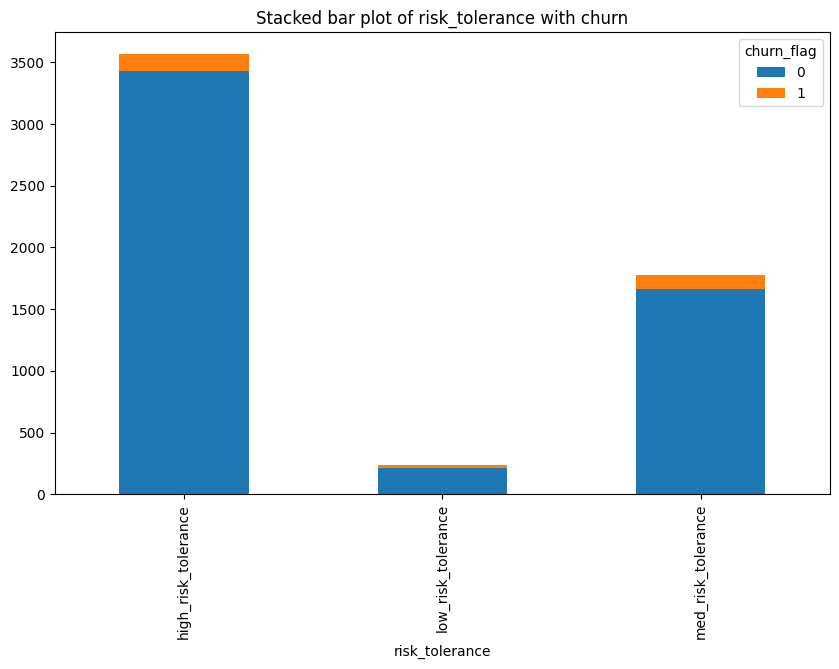

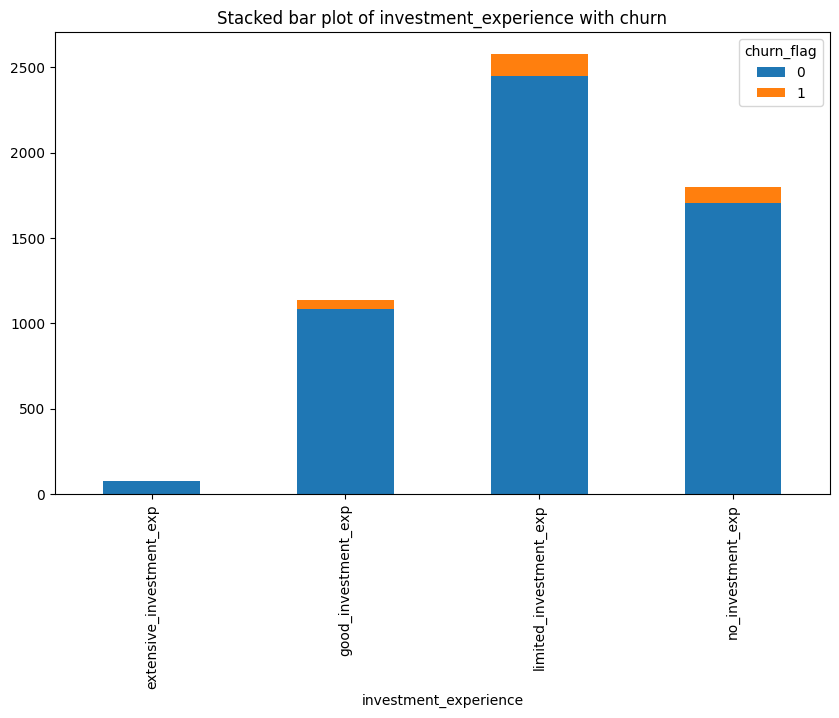

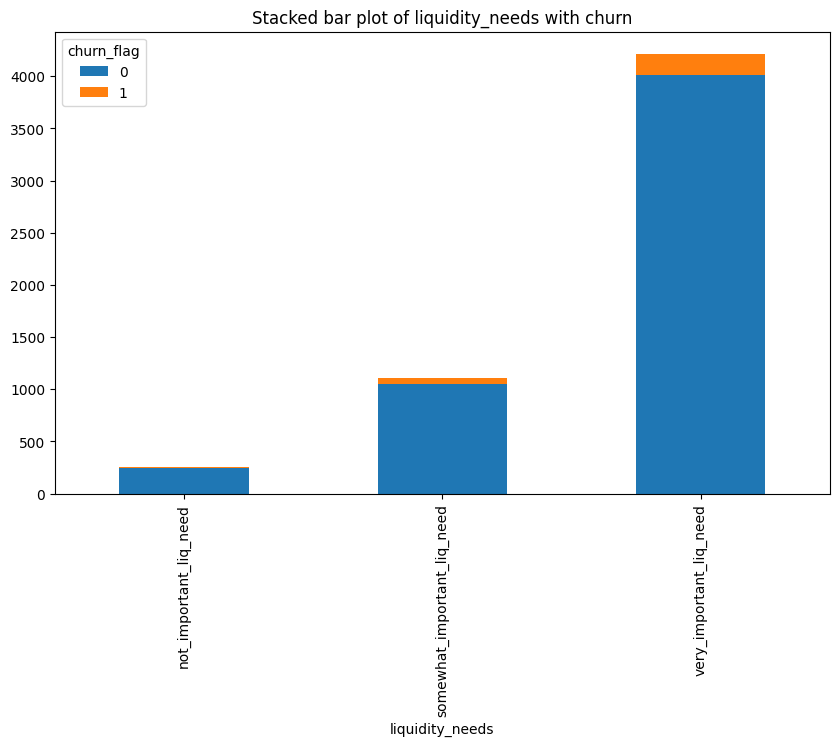

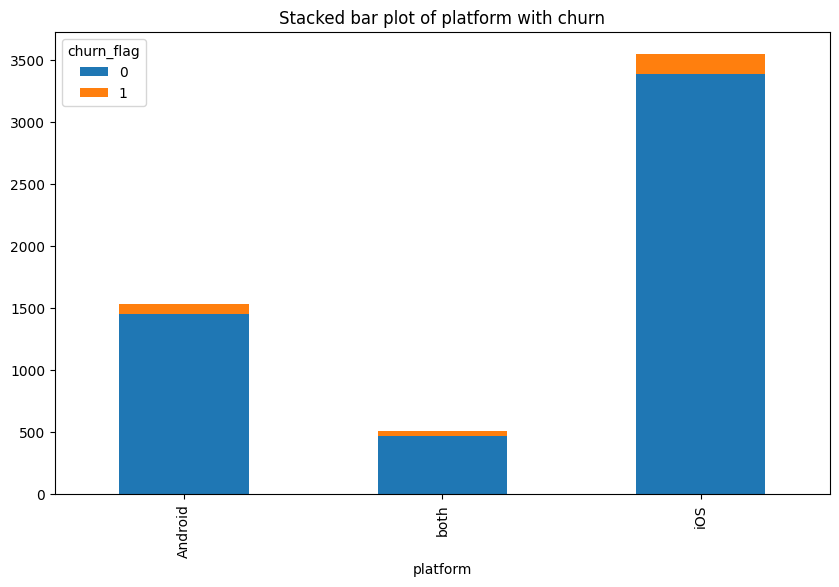

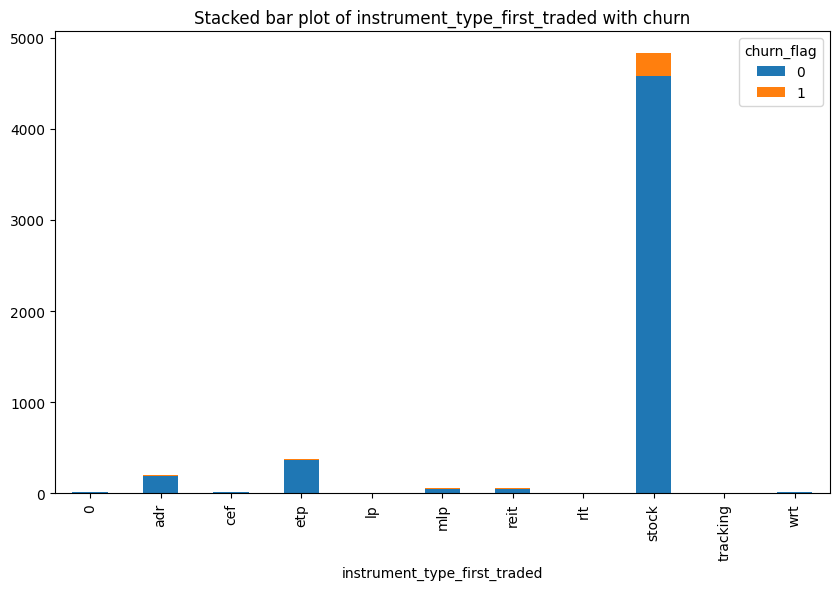

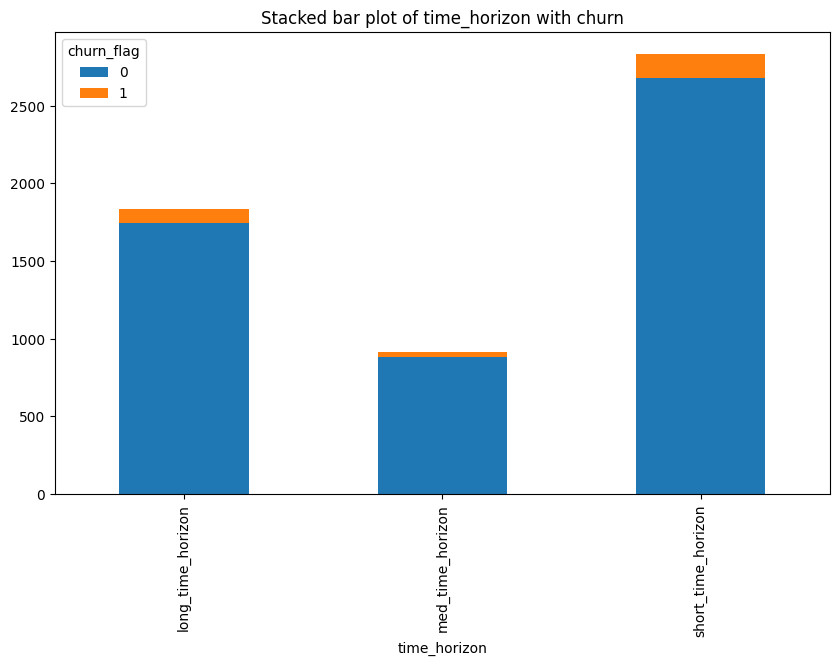

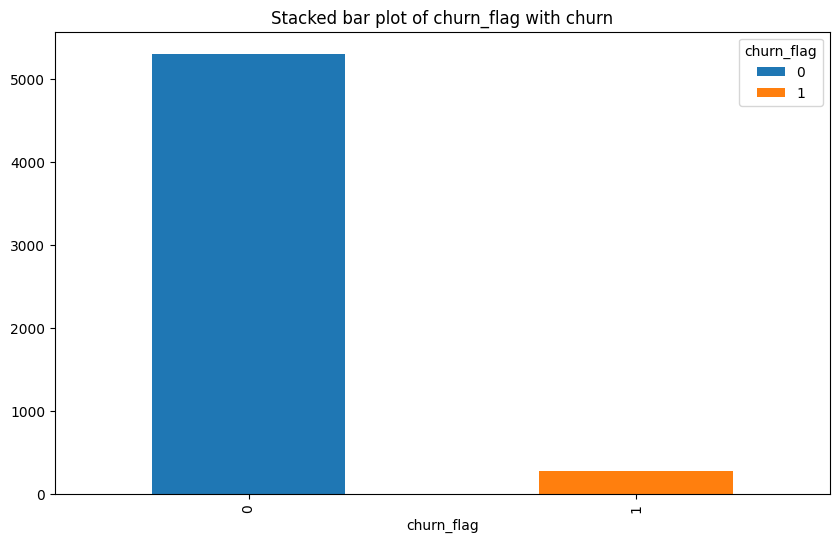

In [66]:
# Bar plots and stacked bar charts to visualize relationships between churn and categorical features.
# Stacked bar plots for churn and categorical variables
for col in cat_cols:
    pd.crosstab(df[col], df['churn_flag']).plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Stacked bar plot of {col} with churn')
    plt.show()


In [72]:
# Perform basic EDA: summary statistics and correlation matrix

# Summary statistics for numerical columns
summary_stats = df.describe()

# Correlation matrix for numerical features
correlation_matrix = df.corr()

# Display the summary statistics and correlation matrix
import ace_tools as tools; tools.display_dataframe_to_user(name="Summary Statistics", dataframe=summary_stats)
tools.display_dataframe_to_user(name="Correlation Matrix", dataframe=correlation_matrix)

# Correlation with churn_flag
correlation_with_churn = correlation_matrix['churn_flag'].sort_values(ascending=False)

ValueError: could not convert string to float: '895044c23edc821881e87da749c01034'

### Variance, Standard Deviation, and Spread of numerical variables

In [67]:
# Variance and Standard Deviation of numerical columns
# NEVER TAKE A SD/VARIANCE ON A SD/VARAINCE COLUMN ALREADY.
df[num_cols].var()
df[num_cols].std()
# See Box plot to visualize spread (already covered in previous sections)


time_spent                         155.080551
first_deposit_amount              2118.323263
deposit_per_time                   998.089605
equity_volatility                 4099.645192
avg_rolling_5day_avg             11918.288103
sd_rolling_5day_avg               4275.917883
avg_rolling_5day_sum             59591.440513
sd_rolling_5day_sum              21379.589415
avg_equity_growth_rate               0.248746
equity_volatility_growth_rate        2.243949
ndays_above10                       68.906396
avg_equity                       11265.546691
equity_delta_start_to_end        11221.127198
ndays_from_2017_08_18               50.788746
max_streak_duration                 17.503329
dtype: float64

### Identifying Outliers using Z-Scores on numerical variables

In [22]:
# Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[num_cols]))
outliers = (z_scores > 3).sum(axis=0)  # Count the number of outliers for each column
print(f'Number of outliers per column: {outliers}')


Number of outliers per column: time_spent              31
first_deposit_amount    62
dtype: int64


C:\Users\cheng\AppData\Local\Temp\ipykernel_16692\3188113231.py:2: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = np.abs(stats.zscore(df[num_cols]))


### Multicollinearity

In [23]:
# Calculate VIF for each numerical column
# Variance Inflation Factor (VIF) checks for multicollinearity between numerical variables:
vif_data = pd.DataFrame()
vif_data['Feature'] = num_cols
vif_data['VIF'] = [variance_inflation_factor(df[num_cols].values, i) for i in range(len(num_cols))]

print(vif_data)


                Feature       VIF
0            time_spent  1.003801
1  first_deposit_amount  1.003801
